## Initial Setup

### Import necessary libraries

In [1]:
import scipy.io as sio
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np

# Sklearn imports
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix, accuracy_score

import py7zr
import os
from scipy.fft import fft, fftfreq
from scipy.signal import welch, spectrogram 
from rpca import RPCA

### Decompress the .mat file if it is compressed

Following patient data and its quality:
- `S1.mat` $\rightarrow$ good patient data
- `S3.mat` $\rightarrow$ good patient data
- `S31.mat` $\rightarrow$ good patient data
- `S32.mat` $\rightarrow$ good patient data
- `S19.mat` $\rightarrow$ medium patient data
- `S29.mat` $\rightarrow$ bad patient data

In [2]:
subject = 1

# Path to the compressed file
compressed_file = f'./data/S{subject}.mat.7z'
mat_file = f'./data/S{subject}.mat'

# Check if the .mat file already exists
if os.path.exists(mat_file):
    print(f"Using existing file {mat_file}")
# Check if the compressed file exists
elif os.path.exists(compressed_file):
    # Extract the file
    with py7zr.SevenZipFile(compressed_file, mode='r') as z:
        z.extractall()
    print(f"Successfully extracted {compressed_file}")
else:
    print(f"File {compressed_file} not found")

Using existing file ./data/S1.mat


### Load the .mat file

In [3]:
eeg_data = sio.loadmat(mat_file)['data']
print(eeg_data.shape)

(64, 1500, 40, 6)


### Define useful global variables

In [4]:
frequency_to_index = {
    8: 0, 9: 1, 10: 2, 11: 3, 12: 4, 13: 5, 14: 6, 15: 7,
    8.2: 8, 9.2: 9, 10.2: 10, 11.2: 11, 12.2: 12, 13.2: 13, 14.2: 14, 15.2: 15,
    8.4: 16, 9.4: 17, 10.4: 18, 11.4: 19, 12.4: 20, 13.4: 21, 14.4: 22, 15.4: 23,
    8.6: 24, 9.6: 25, 10.6: 26, 11.6: 27, 12.6: 28, 13.6: 29, 14.6: 30, 15.6: 31,
    8.8: 32, 9.8: 33, 10.8: 34, 11.8: 35, 12.8: 36, 13.8: 37, 14.8: 38, 15.8: 39,
}

samples = 250 # 250 samples analyzed at once
spacing = 4  # time between samples in ms
fs = 250  # 250 Hz sampling rate


time_range = np.linspace(0, samples * spacing, samples)
freq_range = fftfreq(samples, spacing)[: samples // 2] * 1000
default_freq_xlim = [5, 6, 7, 8, 9, 10, 15, 20, 25, 30, 35]

# Define all available channels with their corresponding indices
relevant_channels = {
    ### Secondary electrodes
    "FCz":18,
    "C5": 24,
    "C3": 25,
    "C1": 26,
    "C2": 28,
    "C4": 29,
    "C6": 30,
    "CPz": 37,
    "P7": 43,
    "P5": 44,
    "P3": 45,
    "P1": 46,
    "P2": 48,
    "P4": 49,
    "P6": 50,
    "P8": 51,

    ### Best electrodes
    ## Frontal
    "Cz": 27,
    
    ## Parietal
    "Pz": 47,
    
    ## Parieto-occipital
    "PO7": 52,
    "PO5": 53,
    "PO3": 54,
    
    "POz": 55,

    "PO4": 56,
    "PO6": 57,
    "PO8": 58,

    ## Occipital
    "O1": 60,
    "Oz": 61,
    "O2": 62,
}

# Electrode sets with number of electrodes as key and channel name/index dict as value
channels_sets = {
    1:  {ch: relevant_channels[ch] for ch in ["Oz"]},
    4:  {ch: relevant_channels[ch] for ch in ["POz", "O1", "Oz", "O2"]},
    8:  {ch: relevant_channels[ch] for ch in ["PO5", "PO3", "POz", "PO4", "PO6", "O1", "Oz", "O2"]},
    9:  {ch: relevant_channels[ch] for ch in ["Pz", "PO5", "PO3", "POz", "PO4", "PO6", "O1", "Oz", "O2"]},
    12: {ch: relevant_channels[ch] for ch in ["Cz", "Pz", "PO7", "PO5", "PO3", "POz", "PO4", "PO6", "PO8", "O1", "Oz", "O2"]},
    14: {ch: relevant_channels[ch] for ch in ["P3", "P4", "Cz", "Pz", "PO7", "PO5", "PO3", "POz", "PO4", "PO6", "PO8", "O1", "Oz", "O2"]},
    16: {ch: relevant_channels[ch] for ch in ["P3", "P1", "P2", "P4", "Cz", "Pz", "PO7", "PO5", "PO3", "POz", "PO4", "PO6", "PO8", "O1", "Oz", "O2"]},
    18: {ch: relevant_channels[ch] for ch in ["P5", "P3", "P1", "P2", "P4", "P6", "Cz", "Pz", "PO7", "PO5", "PO3", "POz", "PO4", "PO6", "PO8", "O1", "Oz", "O2"]},
    20: {ch: relevant_channels[ch] for ch in ["P7", "P5", "P3", "P1", "P2", "P4", "P6", "P8", "Cz", "Pz", "PO7", "PO5", "PO3", "POz", "PO4", "PO6", "PO8", "O1", "Oz", "O2"]},
    22: {ch: relevant_channels[ch] for ch in ["FCz", "CPz", "P7", "P5", "P3", "P1", "P2", "P4", "P6", "P8", "Cz", "Pz", "PO7", "PO5", "PO3", "POz", "PO4", "PO6", "PO8", "O1", "Oz", "O2"]},
    24: {ch: relevant_channels[ch] for ch in ["C1", "C2", "FCz", "CPz", "P7", "P5", "P3", "P1", "P2", "P4", "P6", "P8", "Cz", "Pz", "PO7", "PO5", "PO3", "POz", "PO4", "PO6", "PO8", "O1", "Oz", "O2"]},
    26: {ch: relevant_channels[ch] for ch in ["C3", "C4", "C1", "C2", "FCz", "CPz", "P7", "P5", "P3", "P1", "P2", "P4", "P6", "P8", "Cz", "Pz", "PO7", "PO5", "PO3", "POz", "PO4", "PO6", "PO8", "O1", "Oz", "O2"]},
    28: {ch: relevant_channels[ch] for ch in ["C5", "C6", "C3", "C4", "C1", "C2", "FCz", "CPz", "P7", "P5", "P3", "P1", "P2", "P4", "P6", "P8", "Cz", "Pz", "PO7", "PO5", "PO3", "POz", "PO4", "PO6", "PO8", "O1", "Oz", "O2"]},
}

selected_channels = channels_sets[8]

most_relevant_channels = {
    # "Pz": 47,
    # "POz": 55,
    # For most individuals
    "O1": 60,
    "Oz": 61,
    "O2": 62,
}

# preprocessing_methods list
preprocessing_methods = ["CAR", "RPCA_L", "RPCA_S", "CAR_RPCA_L", "CAR_RPCA_S"]

# variables used for BCI experiments
evoked_frequencies = [8, 10, 12, 15] # frequencies to be used for the BCI experiment (in Hz)
default_evoked_frequency = 8
number_of_windows = 5 # number of windows to split into the useful trial interval (1 second segments along 5 seconds per trial)
number_of_trials = eeg_data.shape[3] # number of trials to use for the BCI experiment
bci_start_sample = 125 # the first 0.5 seconds are discarded
bci_end_sample = 1375 # the last 0.5 seconds are discarded

### Define useful functions

#### Pre-processing

In [5]:
## CAR
def apply_car_filter(eeg_data):
    """
    Apply Common Average Reference (CAR) filtering to EEG data.
    
    CAR subtracts the average of all electrodes from each individual electrode:
    V_i^CAR = V_i^EL - (1/n) * sum(V_j^EL) for all j electrodes
    
    Parameters:
    -----------
    eeg_data : numpy.ndarray
        Input EEG data with shape (channels, samples, frequencies, trials) or (channels, samples) or (trials, channels, samples)
        
    Returns:
    --------
    car_filtered : numpy.ndarray
        CAR-filtered EEG data with the same shape as the input
    """
    
    # Make a copy to avoid modifying the original data
    car_filtered = eeg_data.copy()
    
    # Determine if we have multiple multiple dimensions
    if len(eeg_data.shape) == 4:  # (channels, samples, frequencies, trials)
        n_of_trials = eeg_data.shape[3]
        n_of_frequencies = eeg_data.shape[2]
        # Calculate mean across channels for each trial
        for trial in range(n_of_trials):
            for freq in range(n_of_frequencies):
                channel_mean = np.mean(eeg_data[:, :, freq, trial], axis=0)
                car_filtered[:, :, freq, trial] = eeg_data[:, :, freq, trial] - channel_mean

    elif len(eeg_data.shape) == 3:  # (trials, channels, samples)
        # Calculate mean across channels for each trial
        channel_mean = np.mean(eeg_data, axis=1, keepdims=True)
        # Subtract mean from each channel
        car_filtered = eeg_data - channel_mean

    else:  # (channels, samples)
        # Calculate mean across channels
        channel_mean = np.mean(eeg_data, axis=0, keepdims=True)
        # Subtract mean from each channel
        car_filtered = eeg_data - channel_mean
    
    return car_filtered

## RPCA
def apply_rpca_filter(eeg_data, lambda_value, mu_value, selected_channels, start_sample, end_sample, evoked_frequencies):
    """
    Apply Robust Principal Component Analysis (RPCA) filtering to EEG data.
    
    RPCA decomposes the data matrix into two components:
    L: Low-rank component (representing the common background signal/neural activity)
    S: Sparse component (representing artifacts, outliers, and noise)

    The function processes the data in windows and returns both the low-rank (L) and 
    sparse (S) components separately.

    Args:
        eeg_data: numpy.ndarray
            Input EEG data with shape (channels, samples, frequencies, trials) or 
            (channels, samples) or (trials, channels, samples)
        lambda_value: float
            Regularization parameter for RPCA that controls the sparsity of S
        mu_value: float
            Step size parameter for the optimization algorithm in RPCA
        selected_channels: dict
            Dictionary mapping channel names to their indexes
        start_sample: int
            Starting sample index for processing
        end_sample: int
            Ending sample index for processing
        evoked_frequencies: list
            List of frequencies to be processed

    Returns:
        tuple of numpy.ndarray:
            L_pre_processed_eeg_data: Low-rank component with the same shape as the input
            S_pre_processed_eeg_data: Sparse component with the same shape as the input
    """
    # Get the indexes of selected channels
    selected_channels_indexes = list(selected_channels.values())
    
    # Initialize output array with same shape as input
    L_pre_processed_eeg_data = eeg_data.copy()
    S_pre_processed_eeg_data = eeg_data.copy()
    # Get the number of trials and frequencies
    n_trials = eeg_data.shape[3]
    
    # Process each trial and frequency separately
    for trial_idx in range(n_trials):
        for freq in evoked_frequencies:
            # Split the selected portion of EEG data into windows for processing
            windowed_eeg_data = np.split(
                eeg_data[selected_channels_indexes, start_sample:end_sample, frequency_to_index[freq], trial_idx],
                indices_or_sections=number_of_windows,
                axis=1
            )
            
            # Calculate the width (in samples) of each window for indexing
            window_width = windowed_eeg_data[0].shape[1]
            
            # Process each window separately
            for window_index, window in enumerate(windowed_eeg_data):
                # Initialize L and S components for current window
                L = np.zeros_like(window)
                S = np.zeros_like(window)
                
                # Apply RPCA decomposition to the current window
                # tolerance: convergence criterion
                # max_iteration: maximum number of iterations for the algorithm
                L_temp, S_temp = RPCA(window, lambda_value, mu_value, tolerance=10e-4, max_iteration=1000)
                
                # Store the decomposition results
                L += L_temp
                S += S_temp

                # Calculate the current window's position in the original data
                window_start = start_sample + window_index * window_width
                window_end = start_sample + (window_index + 1) * window_width
                
                # Update the output with filtered data
                L_pre_processed_eeg_data[selected_channels_indexes, window_start:window_end, frequency_to_index[freq], trial_idx] = L
                S_pre_processed_eeg_data[selected_channels_indexes, window_start:window_end, frequency_to_index[freq], trial_idx] = S

    return L_pre_processed_eeg_data, S_pre_processed_eeg_data



#### Feature Extraction

In [6]:
## Feature extraction
def get_label_vector(evoked_frequencies):
    Y = np.zeros(number_of_windows * number_of_trials * len(evoked_frequencies), int)

    for i, frequency in enumerate(evoked_frequencies):
        for j in range(number_of_trials):
            for k in range(number_of_windows):
                Y[i * number_of_trials * number_of_windows + j * number_of_windows + k] += i

    return Y

def get_label_matrix(evoked_frequencies):
    Y = np.ones((number_of_windows * number_of_trials * len(evoked_frequencies), len(evoked_frequencies)), int)

    for i in range(Y.shape[0]):
        for j in range(Y.shape[1]):
            if int(i / (number_of_windows * number_of_trials)) != j:
                Y[i, j] *= -1

    return Y

def get_feature_matrix_from_eeg_frequency_domain(spectogram_data_by_channel_trial_and_frequency, spectogram_frequencies, evoked_frequencies, selected_channels, start_sample, end_sample, select_first_harmonic=False):
    
    # Building X matrix
    number_of_frequencies = len(evoked_frequencies) * (2 if select_first_harmonic else 1)

    X = np.array([np.zeros(len(selected_channels) * number_of_frequencies)])

    frequency_values_to_select = evoked_frequencies
    if select_first_harmonic: # append the first harmonic if needed
        frequency_values_to_select = np.hstack(
            (frequency_values_to_select, np.array(frequency_values_to_select) * 2)
        )

    for i, evoked_frequency in enumerate(evoked_frequencies):

        for j in range(number_of_trials):

            for k in range(number_of_windows):
                temp = np.array([])

                for channel_name in selected_channels.keys():

                    channel_power_points = np.array([])
                    for i, frequency in enumerate(spectogram_frequencies):
                        if frequency not in frequency_values_to_select:
                            continue

                        channel_power_points = np.hstack((
                            channel_power_points,
                            spectogram_data_by_channel_trial_and_frequency[evoked_frequency][j][channel_name][i, k]
                        ))

                    temp = np.hstack((temp, np.array(channel_power_points)))
                X = np.vstack((X, temp))

    # Drop the first line
    X = X[1:, :]

    print('Feature Matrix:', X.shape)

    return X

#### Models

In [7]:
class LeastSquares:
    def __init__(self):
        self.W = None

    def fit(self, X, Y):
        X_plus_bias = np.concatenate((X, np.ones((X.shape[0], 1))), axis=1) # add bias
        
        self.W = np.matmul(np.linalg.pinv(X_plus_bias), Y)

    def predict(self, X):
        X_plus_bias = np.concatenate((X, np.ones((X.shape[0], 1))), axis=1)  # add bias

        predictions = np.matmul(X_plus_bias, self.W)
        
        return np.argmax(predictions, axis=1)

from sklearn.discriminant_analysis import LinearDiscriminantAnalysis
from sklearn.svm import SVC

#### Utils

In [8]:
## Spectogram
def get_spectogram_data(eeg_data, selected_channels, evoked_frequencies, fs, start_sample, end_sample, nperseg=250):
    """
    Compute the Spectogram using Welch's method for all trials and organize by evoked frequencies.
    
    Args:
        eeg_data: EEG data array
        selected_channels: Dictionary of selected channels
        evoked_frequencies: List of evoked frequencies in Hz
        fs: Sampling frequency
        start_sample: Starting sample index
        end_sample: Ending sample index
        nperseg: Segment length for spectrogram
        
    Returns:
        freqs: Frequency array
        t: Time array
        trial_spectrograms_by_frequency: Dictionary of evoked frequencies as keys and spectrogram data for each trial as values
    """
    trial_spectrograms_by_frequency = {freq: [] for freq in evoked_frequencies}

    # Get the indexes of selected channels
    print(f"Selected channels: {selected_channels}")
    print(f"Selected channels values: {selected_channels.values()}")

    # Iterate over all trials
    num_trials = eeg_data.shape[3]
    for trial in range(num_trials):
        for frequency in evoked_frequencies:
            frequency_index = frequency_to_index[frequency]
            # Initialize a dictionary to store spectrogram data for each channel
            Sxx_by_channel = {}

            for channel_name, channel_index in selected_channels.items():
                channel_eeg_data = eeg_data[channel_index, start_sample:end_sample, frequency_index, trial]
                
                # Use spectrogram function from scipy
                freqs, t, Sxx = spectrogram(channel_eeg_data, fs=fs, nperseg=nperseg)

                # Normalize the spectrogram
                Sxx_normalized = Sxx / np.max(Sxx)

                # Select the frequency range
                freq_range_mask = (freqs >= 6) & (freqs <= 32)
                freqs = freqs[freq_range_mask]
                Sxx_normalized = Sxx_normalized[freq_range_mask, :]

                Sxx_by_channel[channel_name] = Sxx_normalized
                print(f"Sxx_by_channel shape for trial {trial + 1}, channel {channel_name}: {Sxx_by_channel[channel_name].shape}")

            trial_spectrograms_by_frequency[frequency].append(Sxx_by_channel)

    return freqs, t, trial_spectrograms_by_frequency

## RPCA Spectogram
def get_spectogram_data_rpca_filtered(eeg_data, selected_channels, evoked_frequencies, fs, start_sample, end_sample, 
                                     lambda_val, mu_val, nperseg=250, filter_type='L'):
    """
    Compute the Spectrogram and apply RPCA filtering for all trials, organized by evoked frequencies.
    
    Args:
        eeg_data: EEG data array
        selected_channels: Dictionary of selected channels
        evoked_frequencies: List of evoked frequencies in Hz
        fs: Sampling frequency
        start_sample: Starting sample index
        end_sample: Ending sample index
        lambda_val: RPCA lambda parameter
        mu_val: RPCA mu parameter
        nperseg: Segment length for spectrogram
        filter_type: 'L' for low-rank component, 'S' for sparse component
        
    Returns:
        freqs: Frequency array
        t: Time array
        trial_spectrograms_by_frequency: Dictionary of evoked frequencies as keys and RPCA-filtered components for each trial as values
    """
    trial_spectrograms_by_frequency = {freq: [] for freq in evoked_frequencies}

    # Get the indexes of selected channels
    print(f"Selected channels: {selected_channels}")
    print(f"Selected channels values: {selected_channels.values()}")

    # Iterate over all trials
    num_trials = eeg_data.shape[3]
    for trial in range(num_trials):
        for frequency in evoked_frequencies:
            frequency_index = frequency_to_index[frequency]
            # Linearize the data for channels for each trial
            channel_linearized_data = []
            
            for channel_index in selected_channels.values():
                channel_eeg_data = eeg_data[channel_index, start_sample:end_sample, frequency_index, trial]
                
                # Use spectrogram function from scipy
                freqs, t, Sxx = spectrogram(channel_eeg_data, fs=fs, nperseg=nperseg)

                # Select the frequency range
                freq_range_mask = (freqs >= 6) & (freqs <= 32)
                freqs = freqs[freq_range_mask]
                Sxx = Sxx[freq_range_mask, :]

                channel_linearized_data.append(Sxx.flatten())
            
            # Stack all linearized data for the current trial
            channel_linearized_data = np.array(channel_linearized_data)

            print(f"Channel linearized data shape for trial {trial + 1}: {channel_linearized_data.shape}")
            
            # Apply RPCA filtering to the spectrogram
            try:
                L_spectogram, S_spectogram = RPCA(channel_linearized_data, lambda_val, mu_val, tolerance=10e-4, max_iteration=1000)
                
                if filter_type == 'L':
                    Sxx_filtered = L_spectogram
                elif filter_type == 'S':
                    Sxx_filtered = S_spectogram
                else:
                    raise ValueError("filter_type must be 'L' or 'S'")

                # Unflatten the data
                Sxx_filtered_by_channel = {}
                for i, channel_name in enumerate(selected_channels.keys()):
                    Sxx_filtered_by_channel[channel_name] = Sxx_filtered[i, :].reshape(Sxx.shape)
                    print(f"Sxx_filtered_by_channel shape for trial {trial + 1}: {Sxx_filtered_by_channel[channel_name].shape}")

                trial_spectrograms_by_frequency[frequency].append(Sxx_filtered_by_channel)

            except Exception as e:
                print(f"RPCA filtering failed for trial {trial + 1}: {e}")
                print("Returning original spectrogram for this trial")
                trial_spectrograms_by_frequency[frequency].append(channel_linearized_data)

    return freqs, t, trial_spectrograms_by_frequency

def plot_spectrogram_comparison(eeg_data, channel_name, selected_channels, trial, frequency, fs, start_sample, end_sample,
                                lambda_val, mu_val, nperseg=250, subject_id=None):
    """
    Plot comparison of 4 spectrogram filtering methods: Original, CAR, RPCA-L, RPCA-S
    
    Args:
        eeg_data: EEG data array
        channel_name: Name of the channel to analyze
        selected_channels: Dictionary of selected channels
        trial: Trial number (1-indexed)
        frequency: Frequency value in Hz
        fs: Sampling frequency
        start_sample: Starting sample index
        end_sample: Ending sample index
        lambda_val: RPCA lambda parameter
        mu_val: RPCA mu parameter
        nperseg: Segment length for spectrogram
        subject_id: Subject identifier for titles
    """
    fig, axes = plt.subplots(3, 2, figsize=(15, 10))
    axes = axes.flatten()
    
    # 1. Original spectrogram
    freqs1, t1, trial_spectrograms1 = get_spectogram_data(
        eeg_data, selected_channels, evoked_frequencies, fs, start_sample, end_sample, nperseg
    )
    im1 = axes[0].pcolormesh(t1, freqs1, trial_spectrograms1[frequency][trial - 1][channel_name])
    axes[0].set_title(f"Original - Trial {trial} - {channel_name}")
    axes[0].set_ylabel('Frequency [Hz]')
    axes[0].set_xlabel('Time [sec]')
    plt.colorbar(im1, ax=axes[0])
    
    # 2. CAR filtered spectrogram
    freqs2, t2, trial_spectrograms2 = get_spectogram_data(
        apply_car_filter(eeg_data), selected_channels, evoked_frequencies, fs, start_sample, end_sample, nperseg
    )
    im2 = axes[1].pcolormesh(t2, freqs2, trial_spectrograms2[frequency][trial - 1][channel_name])
    axes[1].set_title(f"CAR Filtered - Trial {trial} - {channel_name}")
    axes[1].set_ylabel('Frequency [Hz]')
    axes[1].set_xlabel('Time [sec]')
    plt.colorbar(im2, ax=axes[1])
    
    # 3. RPCA L component spectrogram
    freqs3, t3, trial_spectrograms3 = get_spectogram_data_rpca_filtered(
        eeg_data, selected_channels, evoked_frequencies, fs, start_sample, end_sample, 
        lambda_val, mu_val, nperseg, filter_type='L'
    )
    im3 = axes[2].pcolormesh(t3, freqs3, trial_spectrograms3[frequency][trial - 1][channel_name])
    axes[2].set_title(f"RPCA-L Filtered - Trial {trial} - {channel_name}")
    axes[2].set_ylabel('Frequency [Hz]')
    axes[2].set_xlabel('Time [sec]')
    plt.colorbar(im3, ax=axes[2])
    
    # 4. RPCA S component spectrogram
    freqs4, t4, trial_spectrograms4 = get_spectogram_data_rpca_filtered(
        eeg_data, selected_channels, evoked_frequencies, fs, start_sample, end_sample, 
        lambda_val, mu_val, nperseg, filter_type='S'
    )
    im4 = axes[3].pcolormesh(t4, freqs4, trial_spectrograms4[frequency][trial - 1][channel_name])
    axes[3].set_title(f"RPCA-S Filtered - Trial {trial} - {channel_name}")
    axes[3].set_ylabel('Frequency [Hz]')
    axes[3].set_xlabel('Time [sec]')
    plt.colorbar(im4, ax=axes[3])
    
    # 5. CAR + RPCA L component spectrogram
    freqs5, t5, trial_spectrograms5 = get_spectogram_data_rpca_filtered(
        apply_car_filter(eeg_data), selected_channels, evoked_frequencies, fs, start_sample, end_sample, 
        lambda_val, mu_val, nperseg, filter_type='L'
    )
    im5 = axes[4].pcolormesh(t5, freqs5, trial_spectrograms5[frequency][trial - 1][channel_name])
    axes[4].set_title(f"CAR + RPCA-L Filtered - Trial {trial} - {channel_name}")
    axes[4].set_ylabel('Frequency [Hz]')
    axes[4].set_xlabel('Time [sec]')
    plt.colorbar(im5, ax=axes[4])
    
    # 6. CAR + RPCA S component spectrogram
    freqs6, t6, trial_spectrograms6 = get_spectogram_data_rpca_filtered(
        apply_car_filter(eeg_data), selected_channels, evoked_frequencies, fs, start_sample, end_sample, 
        lambda_val, mu_val, nperseg, filter_type='S'
    )
    im6 = axes[5].pcolormesh(t6, freqs6, trial_spectrograms6[frequency][trial - 1][channel_name])
    axes[5].set_title(f"CAR + RPCA-S Filtered - Trial {trial} - {channel_name}")
    axes[5].set_ylabel('Frequency [Hz]')
    axes[5].set_xlabel('Time [sec]')
    plt.colorbar(im6, ax=axes[5])
    
    # Add overall title
    subject_str = f"Subject {subject_id}"
    fig.suptitle(f"{subject_str} - Frequency {frequency} Hz - RPCA channels: {list(selected_channels.keys())} - RPCA Parameters: λ={lambda_val:.6f}, μ={mu_val:.6f}", fontsize=14)
    
    plt.tight_layout()
    plt.show()
    
    return fig, axes


In [9]:
def plot_accuracy_boxplot(ls_accuracies, lda_accuracies, svm_accuracies, methods, indices, group_name, filename, selected_channels):
    """
    Plots and saves a boxplot of accuracies for the given group of patients.

    Args:
        ls_accuracies (dict): Least Squares accuracies per method.
        lda_accuracies (dict): LDA accuracies per method.
        svm_accuracies (dict): SVM accuracies per method.
        methods (list): List of preprocessing method names.
        indices (list or None): Indices of patients to include (None for all).
        group_name (str): Name of the group for the plot title.
        filename (str): Filename to save the plot.
        selected_channels (list): List of selected channels (for title).
    """
    plt.figure(figsize=(14, 8))
    data = []
    labels = []
    for method in methods:
        if indices is None:
            data.append(ls_accuracies[method])
            data.append(lda_accuracies[method])
            data.append(svm_accuracies[method])
        else:
            data.append(np.array(ls_accuracies[method])[indices])
            data.append(np.array(lda_accuracies[method])[indices])
            data.append(np.array(svm_accuracies[method])[indices])
        labels.append(f"{method}-LS")
        labels.append(f"{method}-LDA")
        labels.append(f"{method}-SVM")
    plt.boxplot(data, labels=labels, patch_artist=True)
    plt.xticks(rotation=45, ha='right')
    plt.ylabel('Accuracy')
    plt.title(f'Distribution of Accuracies Across Subjects ({group_name}, {len(selected_channels)} channels)')
    plt.grid(axis='y', linestyle='--', alpha=0.7)
    plt.tight_layout()
    plt.savefig(filename, dpi=300)
    plt.show()


## RPCA Parameter Optimization for Spectrogram Data

In [10]:
# Define parameter ranges for RPCA optimization on spectrogram data
# Using spectrogram dimensions to calculate base lambda
channel_name = "Oz"
freqs, t, Sxx = get_spectogram_data(
    eeg_data,
    selected_channels,
    evoked_frequencies,
    fs=fs,
    start_sample=bci_start_sample,
    end_sample=bci_end_sample
)

# Base lambda calculated from spectrogram matrix dimensions
lamb_zero_spectogram = 1 / np.sqrt(max(Sxx[default_evoked_frequency][0][channel_name].shape))
mu_denominators = [1/10, 1, 2, 4, 10]

lamb_values_spectogram = [20 * lamb_zero_spectogram, 5 * lamb_zero_spectogram, lamb_zero_spectogram, lamb_zero_spectogram / 1.5,
                          lamb_zero_spectogram / 2, lamb_zero_spectogram / 2.5, lamb_zero_spectogram / 3, lamb_zero_spectogram / 3.5,
                          lamb_zero_spectogram / 4, lamb_zero_spectogram / 5, lamb_zero_spectogram / 6, 
                          lamb_zero_spectogram / 7, lamb_zero_spectogram / 8, lamb_zero_spectogram / 9, 
                          lamb_zero_spectogram / 10, lamb_zero_spectogram / 15, lamb_zero_spectogram / 20,
                          lamb_zero_spectogram / 25, lamb_zero_spectogram / 30, lamb_zero_spectogram / 35]

print(f"Spectrogram shape: {Sxx[default_evoked_frequency][0][channel_name].shape}")
print(f"Base lambda for spectrogram: {lamb_zero_spectogram:.6f}")
print(f"Lambda range: {min(lamb_values_spectogram):.6f} to {max(lamb_values_spectogram):.6f}")

Selected channels: {'PO5': 53, 'PO3': 54, 'POz': 55, 'PO4': 56, 'PO6': 57, 'O1': 60, 'Oz': 61, 'O2': 62}
Selected channels values: dict_values([53, 54, 55, 56, 57, 60, 61, 62])
Sxx_by_channel shape for trial 1, channel PO5: (27, 5)
Sxx_by_channel shape for trial 1, channel PO3: (27, 5)
Sxx_by_channel shape for trial 1, channel POz: (27, 5)
Sxx_by_channel shape for trial 1, channel PO4: (27, 5)
Sxx_by_channel shape for trial 1, channel PO6: (27, 5)
Sxx_by_channel shape for trial 1, channel O1: (27, 5)
Sxx_by_channel shape for trial 1, channel Oz: (27, 5)
Sxx_by_channel shape for trial 1, channel O2: (27, 5)
Sxx_by_channel shape for trial 1, channel PO5: (27, 5)
Sxx_by_channel shape for trial 1, channel PO3: (27, 5)
Sxx_by_channel shape for trial 1, channel POz: (27, 5)
Sxx_by_channel shape for trial 1, channel PO4: (27, 5)
Sxx_by_channel shape for trial 1, channel PO6: (27, 5)
Sxx_by_channel shape for trial 1, channel O1: (27, 5)
Sxx_by_channel shape for trial 1, channel Oz: (27, 5)
Sxx

In [11]:
# RPCA parameter optimization for spectrogram data
print(f"Testing RPCA parameters on spectrogram data for Subject {subject}...")
print(f"Testing {len(lamb_values_spectogram)} lambda values and {len(mu_denominators)} mu values")

# Initialize best lamb and mu for each preprocessing method
best_lamb_spectogram_list = []
best_mu_spectogram_list = []
max_accuracy_list = []

for i, method in enumerate(preprocessing_methods):
    if method == 'CAR':
        best_lamb_spectogram = None
        best_mu_spectogram = None
        max_accuracy = None
    else:
        best_lamb_spectogram = lamb_zero_spectogram / 2
        best_mu_spectogram = best_lamb_spectogram / 2
        max_accuracy = 0

    best_lamb_spectogram_list.append(best_lamb_spectogram)
    best_mu_spectogram_list.append(best_mu_spectogram)
    max_accuracy_list.append(max_accuracy)


# Create label representations for classification
# Y_vector: 1D array with class labels (e.g., [0, 1, 2, 0, 1, ...])
Y_vector = get_label_vector(evoked_frequencies)

# Y_matrix: One-hot encoded matrix representation of labels
# (e.g., [[1,-1,-1], [-1,1,-1], [-1,-1,1], [1,-1,-1], ...])
Y_matrix = get_label_matrix(evoked_frequencies)

for i, method in enumerate(preprocessing_methods):
    if method == 'CAR':
        continue

    for j, lamb in enumerate(lamb_values_spectogram):
        for k, mu_denominator in enumerate(mu_denominators):
            mu = lamb / mu_denominator
            
            try:
                if method == 'RPCA_L':
                    freqs, t, Sxx = get_spectogram_data_rpca_filtered(eeg_data, selected_channels, evoked_frequencies, fs, bci_start_sample, bci_end_sample, lamb, mu, filter_type='L')
                    X = get_feature_matrix_from_eeg_frequency_domain(Sxx, freqs, evoked_frequencies, selected_channels, bci_start_sample, bci_end_sample, select_first_harmonic=True)
                elif method == 'RPCA_S':
                    freqs, t, Sxx = get_spectogram_data_rpca_filtered(eeg_data, selected_channels, evoked_frequencies, fs, bci_start_sample, bci_end_sample, lamb, mu, filter_type='S')
                    X = get_feature_matrix_from_eeg_frequency_domain(Sxx, freqs, evoked_frequencies, selected_channels, bci_start_sample, bci_end_sample, select_first_harmonic=True)
                elif method == 'CAR_RPCA_L':
                    freqs, t, Sxx = get_spectogram_data_rpca_filtered(apply_car_filter(eeg_data), selected_channels, evoked_frequencies, fs, bci_start_sample, bci_end_sample, lamb, mu, filter_type='L')
                    X = get_feature_matrix_from_eeg_frequency_domain(Sxx, freqs, evoked_frequencies, selected_channels, bci_start_sample, bci_end_sample, select_first_harmonic=True)
                elif method == 'CAR_RPCA_S':
                    freqs, t, Sxx = get_spectogram_data_rpca_filtered(apply_car_filter(eeg_data), selected_channels, evoked_frequencies, fs, bci_start_sample, bci_end_sample, lamb, mu, filter_type='S')
                    X = get_feature_matrix_from_eeg_frequency_domain(Sxx, freqs, evoked_frequencies, selected_channels, bci_start_sample, bci_end_sample, select_first_harmonic=True)

                # Train SVM model
                X_train, X_val, \
                Y_vector_train, Y_vector_val, \
                Y_matrix_train, Y_matrix_val = train_test_split(
                    X,
                    Y_vector,
                    Y_matrix,
                    test_size=0.2,
                    stratify=Y_vector,
                    random_state=42  # For reproducibility
                )
                
                # Train SVM model
                svm_model = SVC(kernel='linear')
                svm_model.fit(X_train, Y_vector_train)
                y_svm_pred = svm_model.predict(X_val)
                svm_acc = accuracy_score(Y_vector_val, y_svm_pred)

                print(f"SVM accuracy: {svm_acc:.4f}")
                
                if svm_acc > max_accuracy_list[i]:
                    max_accuracy_list[i] = svm_acc
                    best_lamb_spectogram_list[i] = lamb
                    best_mu_spectogram_list[i] = mu
                    best_lamb_spectogram_list[i] = lamb
                    best_mu_spectogram_list[i] = mu
                    
            except Exception as e:
                raise e
                # Skip parameter combinations that cause numerical issues
                continue

    print(f"\\nBest parameters found for {method}:")
    print(f"Lambda: {best_lamb_spectogram_list[i]:.6f}")
    print(f"Lambda Zero: {lamb_zero_spectogram:.6f}")
    print(f"Mu: {best_mu_spectogram_list[i]:.6f}")
    print(f"SVM accuracy: {max_accuracy_list[i]:.4f}")

Testing RPCA parameters on spectrogram data for Subject 1...
Testing 20 lambda values and 5 mu values
Selected channels: {'PO5': 53, 'PO3': 54, 'POz': 55, 'PO4': 56, 'PO6': 57, 'O1': 60, 'Oz': 61, 'O2': 62}
Selected channels values: dict_values([53, 54, 55, 56, 57, 60, 61, 62])
Channel linearized data shape for trial 1: (8, 135)
Sxx_filtered_by_channel shape for trial 1: (27, 5)
Sxx_filtered_by_channel shape for trial 1: (27, 5)
Sxx_filtered_by_channel shape for trial 1: (27, 5)
Sxx_filtered_by_channel shape for trial 1: (27, 5)
Sxx_filtered_by_channel shape for trial 1: (27, 5)
Sxx_filtered_by_channel shape for trial 1: (27, 5)
Sxx_filtered_by_channel shape for trial 1: (27, 5)
Sxx_filtered_by_channel shape for trial 1: (27, 5)
Channel linearized data shape for trial 1: (8, 135)
Sxx_filtered_by_channel shape for trial 1: (27, 5)
Sxx_filtered_by_channel shape for trial 1: (27, 5)
Sxx_filtered_by_channel shape for trial 1: (27, 5)
Sxx_filtered_by_channel shape for trial 1: (27, 5)
Sxx_f

In [12]:
for i, method in enumerate(preprocessing_methods):
    print(method, max_accuracy_list[i])


CAR None
RPCA_L 0.7916666666666666
RPCA_S 0.9583333333333334
CAR_RPCA_L 0.875
CAR_RPCA_S 0.875


## Spectrogram Comparison: Original, CAR, RPCA-L, and RPCA-S

Generating spectrogram comparisons for all 6 trials...
Using optimized parameters: λ=0.096225, μ=0.048113
\nGenerating comparison for Trial 1...
Selected channels: {'PO5': 53, 'PO3': 54, 'POz': 55, 'PO4': 56, 'PO6': 57, 'O1': 60, 'Oz': 61, 'O2': 62}
Selected channels values: dict_values([53, 54, 55, 56, 57, 60, 61, 62])
Sxx_by_channel shape for trial 1, channel PO5: (27, 5)
Sxx_by_channel shape for trial 1, channel PO3: (27, 5)
Sxx_by_channel shape for trial 1, channel POz: (27, 5)
Sxx_by_channel shape for trial 1, channel PO4: (27, 5)
Sxx_by_channel shape for trial 1, channel PO6: (27, 5)
Sxx_by_channel shape for trial 1, channel O1: (27, 5)
Sxx_by_channel shape for trial 1, channel Oz: (27, 5)
Sxx_by_channel shape for trial 1, channel O2: (27, 5)
Sxx_by_channel shape for trial 1, channel PO5: (27, 5)
Sxx_by_channel shape for trial 1, channel PO3: (27, 5)
Sxx_by_channel shape for trial 1, channel POz: (27, 5)
Sxx_by_channel shape for trial 1, channel PO4: (27, 5)
Sxx_by_channel shape 

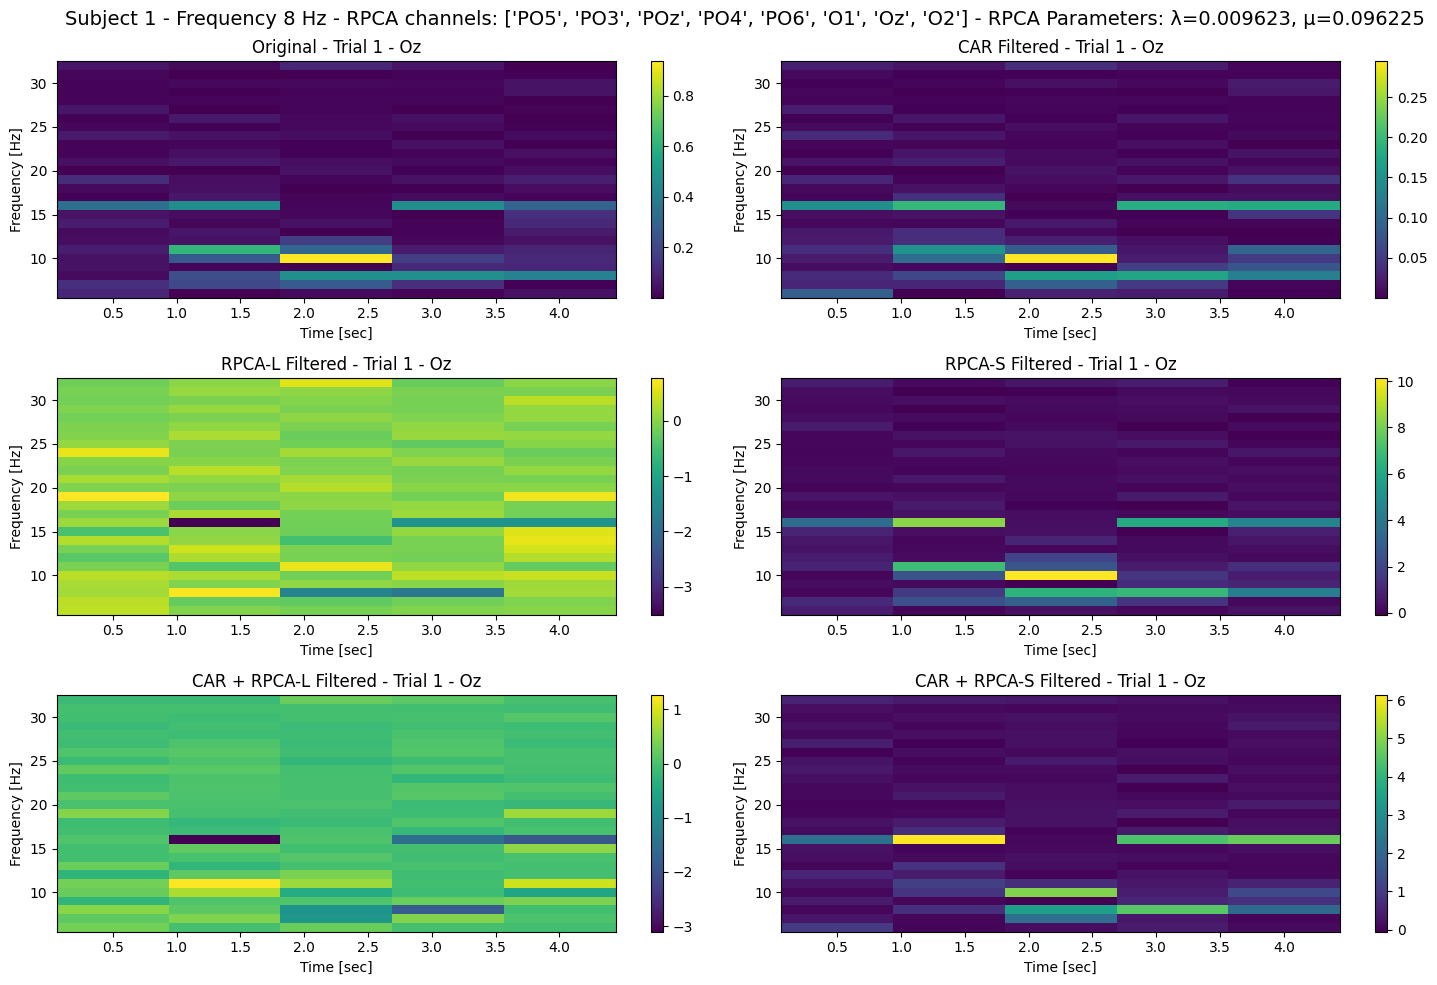

\nGenerating comparison for Trial 2...
Selected channels: {'PO5': 53, 'PO3': 54, 'POz': 55, 'PO4': 56, 'PO6': 57, 'O1': 60, 'Oz': 61, 'O2': 62}
Selected channels values: dict_values([53, 54, 55, 56, 57, 60, 61, 62])
Sxx_by_channel shape for trial 1, channel PO5: (27, 5)
Sxx_by_channel shape for trial 1, channel PO3: (27, 5)
Sxx_by_channel shape for trial 1, channel POz: (27, 5)
Sxx_by_channel shape for trial 1, channel PO4: (27, 5)
Sxx_by_channel shape for trial 1, channel PO6: (27, 5)
Sxx_by_channel shape for trial 1, channel O1: (27, 5)
Sxx_by_channel shape for trial 1, channel Oz: (27, 5)
Sxx_by_channel shape for trial 1, channel O2: (27, 5)
Sxx_by_channel shape for trial 1, channel PO5: (27, 5)
Sxx_by_channel shape for trial 1, channel PO3: (27, 5)
Sxx_by_channel shape for trial 1, channel POz: (27, 5)
Sxx_by_channel shape for trial 1, channel PO4: (27, 5)
Sxx_by_channel shape for trial 1, channel PO6: (27, 5)
Sxx_by_channel shape for trial 1, channel O1: (27, 5)
Sxx_by_channel sha

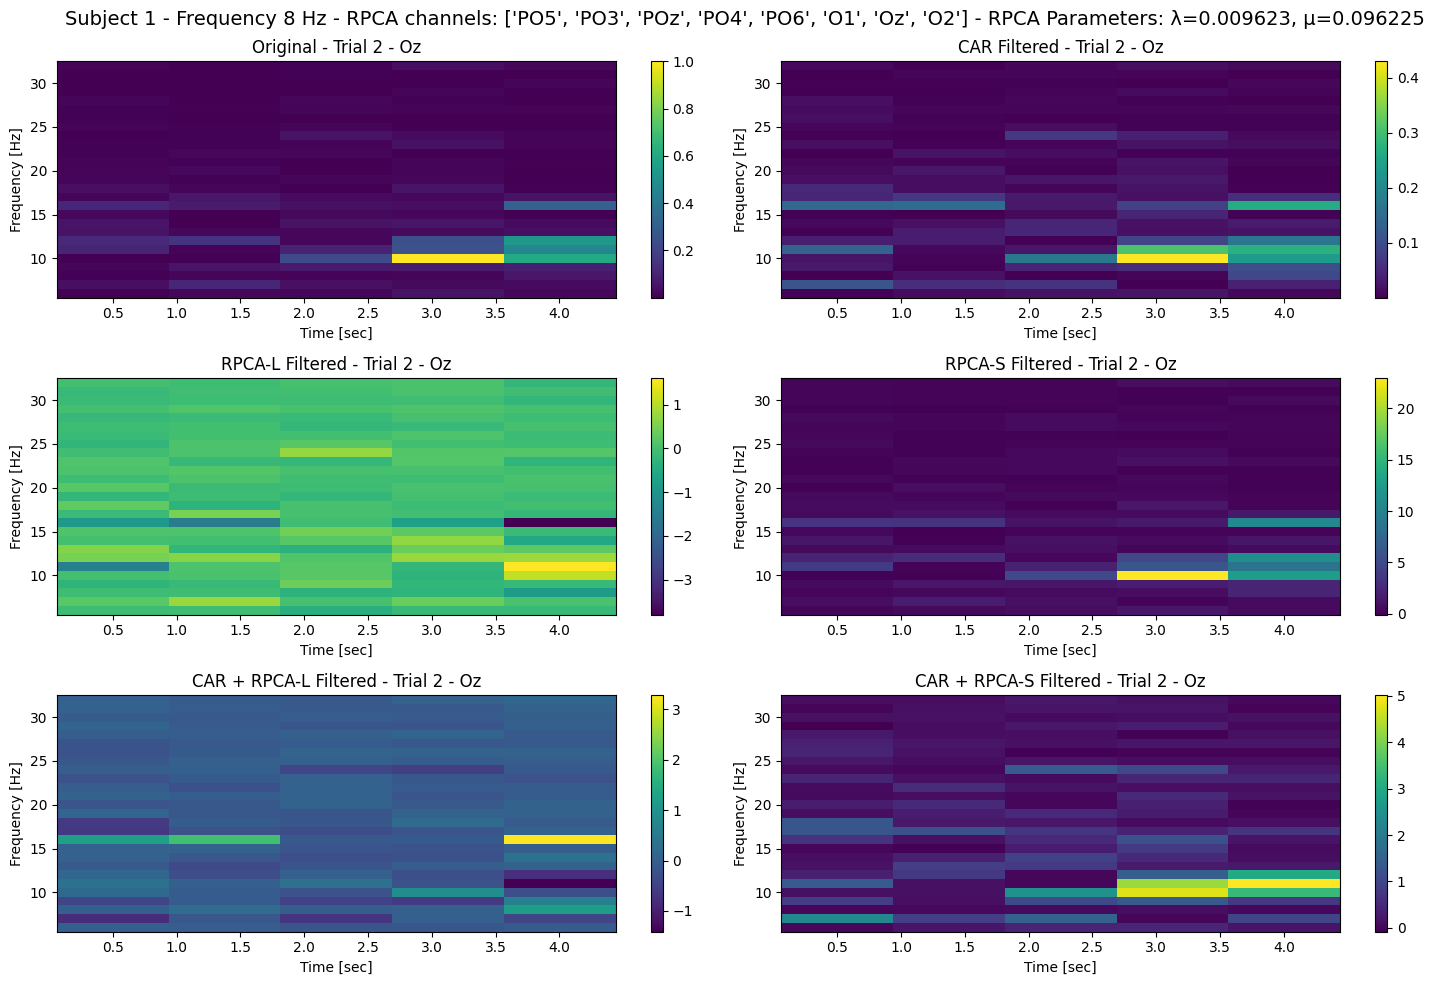

\nGenerating comparison for Trial 3...
Selected channels: {'PO5': 53, 'PO3': 54, 'POz': 55, 'PO4': 56, 'PO6': 57, 'O1': 60, 'Oz': 61, 'O2': 62}
Selected channels values: dict_values([53, 54, 55, 56, 57, 60, 61, 62])
Sxx_by_channel shape for trial 1, channel PO5: (27, 5)
Sxx_by_channel shape for trial 1, channel PO3: (27, 5)
Sxx_by_channel shape for trial 1, channel POz: (27, 5)
Sxx_by_channel shape for trial 1, channel PO4: (27, 5)
Sxx_by_channel shape for trial 1, channel PO6: (27, 5)
Sxx_by_channel shape for trial 1, channel O1: (27, 5)
Sxx_by_channel shape for trial 1, channel Oz: (27, 5)
Sxx_by_channel shape for trial 1, channel O2: (27, 5)
Sxx_by_channel shape for trial 1, channel PO5: (27, 5)
Sxx_by_channel shape for trial 1, channel PO3: (27, 5)
Sxx_by_channel shape for trial 1, channel POz: (27, 5)
Sxx_by_channel shape for trial 1, channel PO4: (27, 5)
Sxx_by_channel shape for trial 1, channel PO6: (27, 5)
Sxx_by_channel shape for trial 1, channel O1: (27, 5)
Sxx_by_channel sha

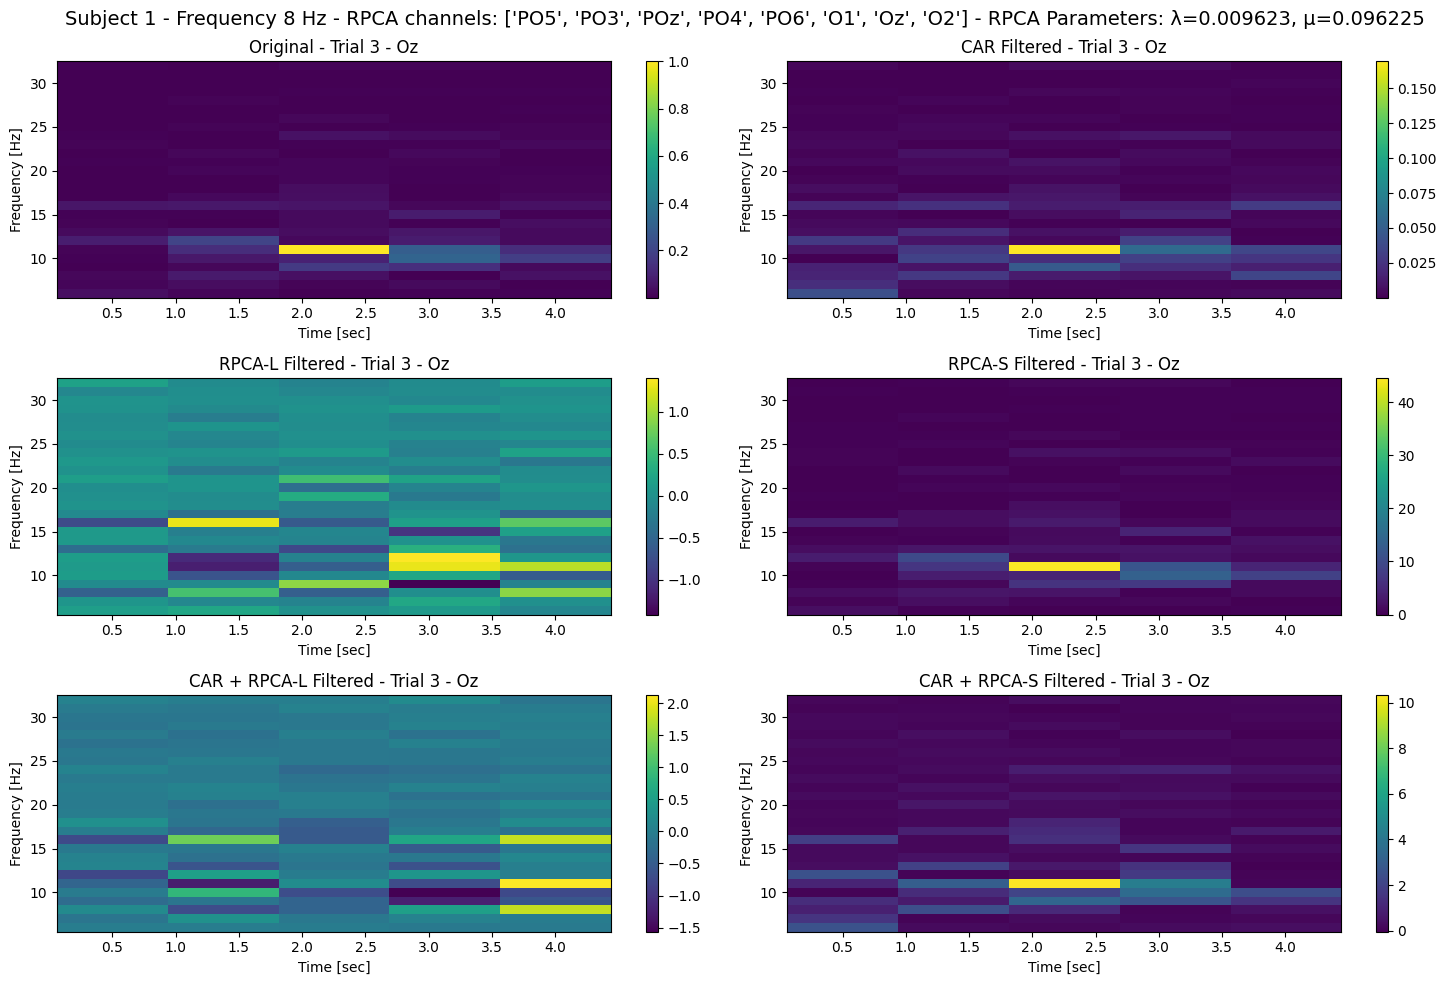

\nGenerating comparison for Trial 4...
Selected channels: {'PO5': 53, 'PO3': 54, 'POz': 55, 'PO4': 56, 'PO6': 57, 'O1': 60, 'Oz': 61, 'O2': 62}
Selected channels values: dict_values([53, 54, 55, 56, 57, 60, 61, 62])
Sxx_by_channel shape for trial 1, channel PO5: (27, 5)
Sxx_by_channel shape for trial 1, channel PO3: (27, 5)
Sxx_by_channel shape for trial 1, channel POz: (27, 5)
Sxx_by_channel shape for trial 1, channel PO4: (27, 5)
Sxx_by_channel shape for trial 1, channel PO6: (27, 5)
Sxx_by_channel shape for trial 1, channel O1: (27, 5)
Sxx_by_channel shape for trial 1, channel Oz: (27, 5)
Sxx_by_channel shape for trial 1, channel O2: (27, 5)
Sxx_by_channel shape for trial 1, channel PO5: (27, 5)
Sxx_by_channel shape for trial 1, channel PO3: (27, 5)
Sxx_by_channel shape for trial 1, channel POz: (27, 5)
Sxx_by_channel shape for trial 1, channel PO4: (27, 5)
Sxx_by_channel shape for trial 1, channel PO6: (27, 5)
Sxx_by_channel shape for trial 1, channel O1: (27, 5)
Sxx_by_channel sha

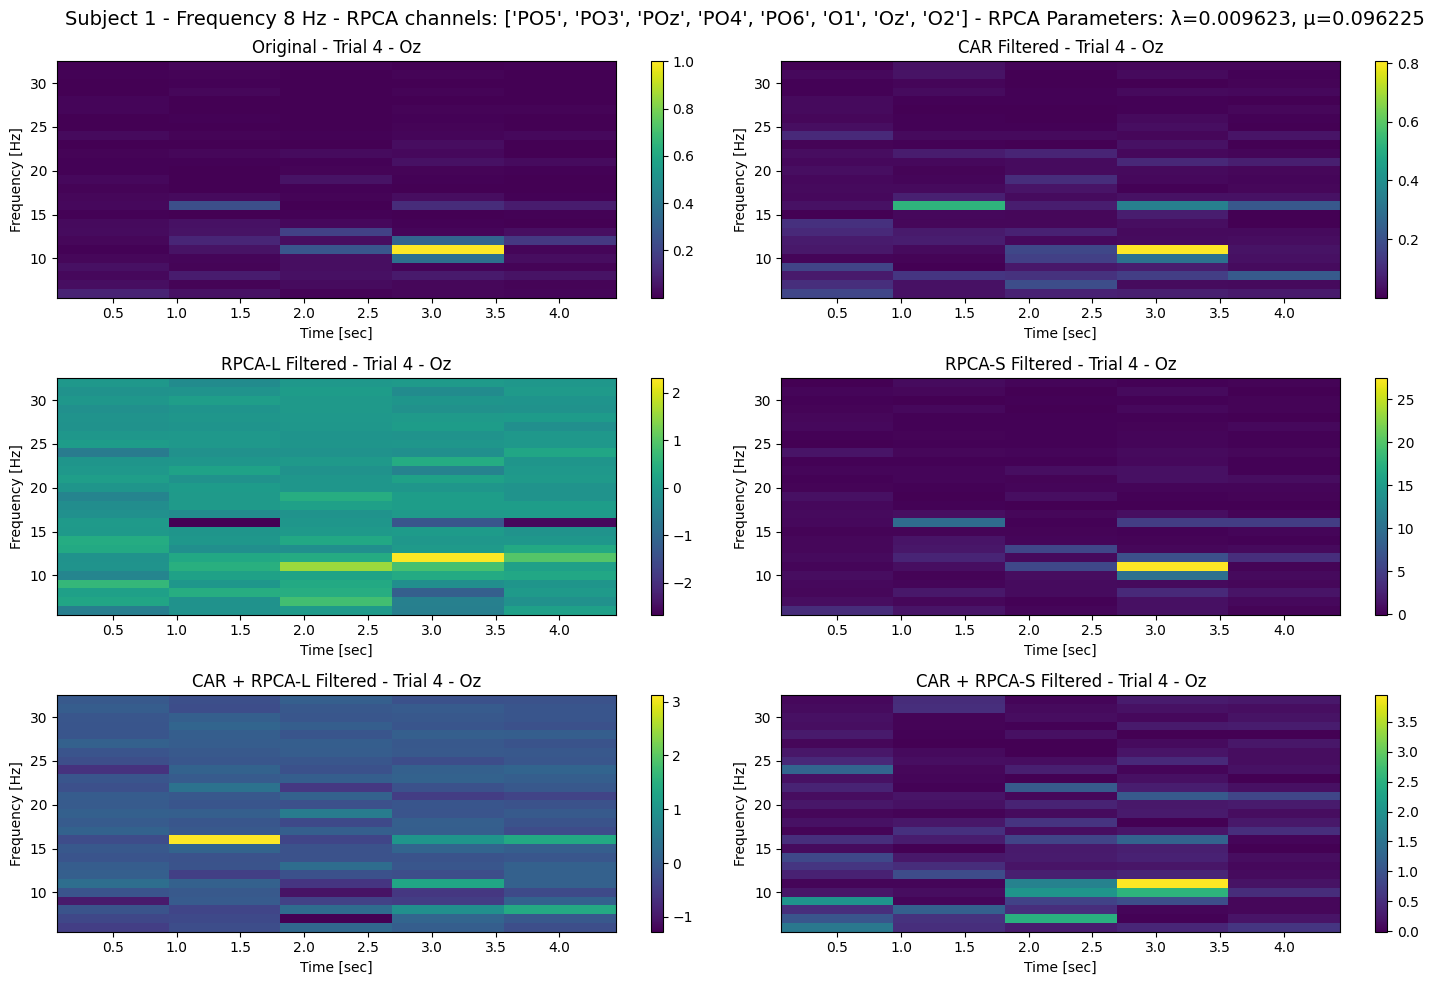

\nGenerating comparison for Trial 5...
Selected channels: {'PO5': 53, 'PO3': 54, 'POz': 55, 'PO4': 56, 'PO6': 57, 'O1': 60, 'Oz': 61, 'O2': 62}
Selected channels values: dict_values([53, 54, 55, 56, 57, 60, 61, 62])
Sxx_by_channel shape for trial 1, channel PO5: (27, 5)
Sxx_by_channel shape for trial 1, channel PO3: (27, 5)
Sxx_by_channel shape for trial 1, channel POz: (27, 5)
Sxx_by_channel shape for trial 1, channel PO4: (27, 5)
Sxx_by_channel shape for trial 1, channel PO6: (27, 5)
Sxx_by_channel shape for trial 1, channel O1: (27, 5)
Sxx_by_channel shape for trial 1, channel Oz: (27, 5)
Sxx_by_channel shape for trial 1, channel O2: (27, 5)
Sxx_by_channel shape for trial 1, channel PO5: (27, 5)
Sxx_by_channel shape for trial 1, channel PO3: (27, 5)
Sxx_by_channel shape for trial 1, channel POz: (27, 5)
Sxx_by_channel shape for trial 1, channel PO4: (27, 5)
Sxx_by_channel shape for trial 1, channel PO6: (27, 5)
Sxx_by_channel shape for trial 1, channel O1: (27, 5)
Sxx_by_channel sha

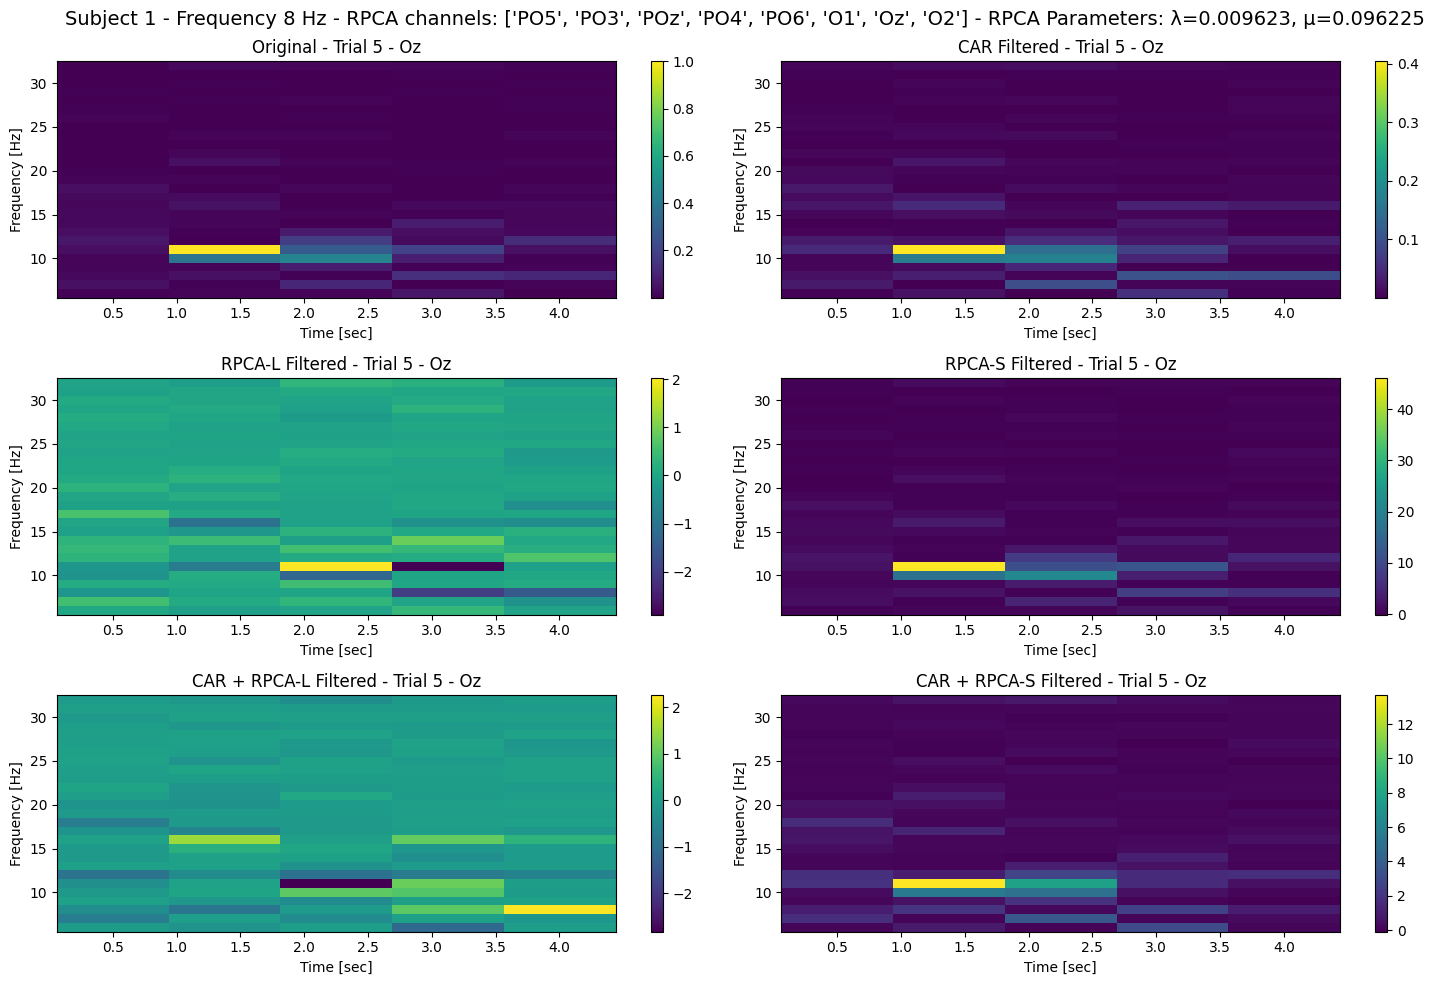

\nGenerating comparison for Trial 6...
Selected channels: {'PO5': 53, 'PO3': 54, 'POz': 55, 'PO4': 56, 'PO6': 57, 'O1': 60, 'Oz': 61, 'O2': 62}
Selected channels values: dict_values([53, 54, 55, 56, 57, 60, 61, 62])
Sxx_by_channel shape for trial 1, channel PO5: (27, 5)
Sxx_by_channel shape for trial 1, channel PO3: (27, 5)
Sxx_by_channel shape for trial 1, channel POz: (27, 5)
Sxx_by_channel shape for trial 1, channel PO4: (27, 5)
Sxx_by_channel shape for trial 1, channel PO6: (27, 5)
Sxx_by_channel shape for trial 1, channel O1: (27, 5)
Sxx_by_channel shape for trial 1, channel Oz: (27, 5)
Sxx_by_channel shape for trial 1, channel O2: (27, 5)
Sxx_by_channel shape for trial 1, channel PO5: (27, 5)
Sxx_by_channel shape for trial 1, channel PO3: (27, 5)
Sxx_by_channel shape for trial 1, channel POz: (27, 5)
Sxx_by_channel shape for trial 1, channel PO4: (27, 5)
Sxx_by_channel shape for trial 1, channel PO6: (27, 5)
Sxx_by_channel shape for trial 1, channel O1: (27, 5)
Sxx_by_channel sha

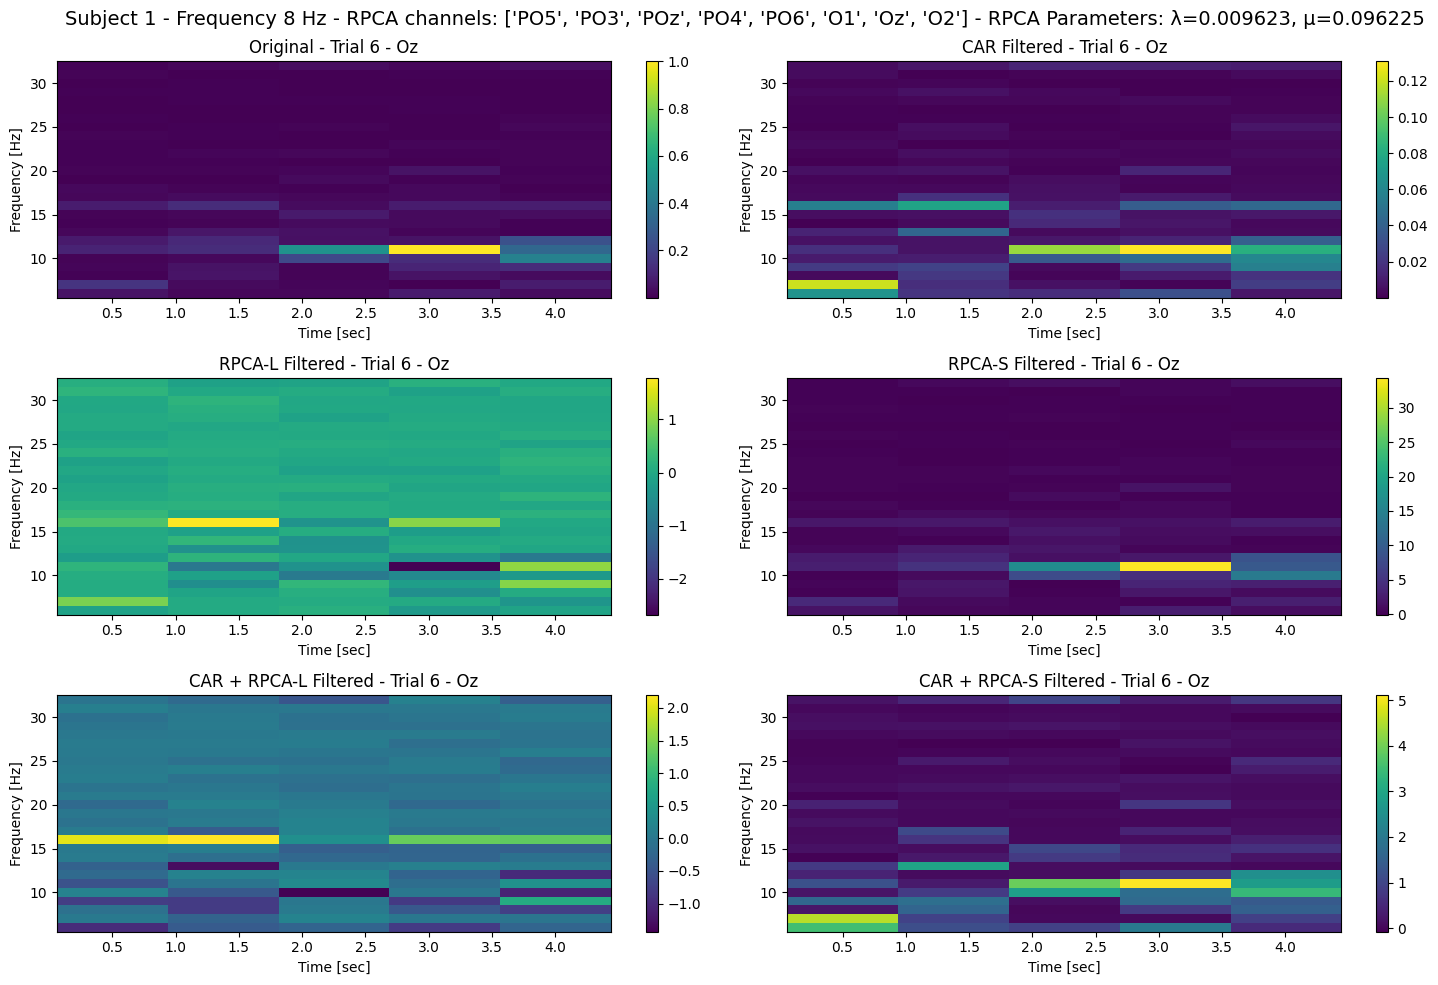

In [13]:
# Generate comparison plots for all trials using optimized parameters
print(f"Generating spectrogram comparisons for all {number_of_trials} trials...")
print(f"Using optimized parameters: λ={best_lamb_spectogram:.6f}, μ={best_mu_spectogram:.6f}")

for trial in range(1, number_of_trials + 1):
    print(f"\\nGenerating comparison for Trial {trial}...")
    plot_spectrogram_comparison(
        eeg_data=eeg_data,
        channel_name=channel_name,
        selected_channels=selected_channels,
        trial=trial,
        frequency=default_evoked_frequency,
        fs=fs,
        start_sample=bci_start_sample,
        end_sample=bci_end_sample,
        lambda_val=best_lamb_spectogram_list[2],
        mu_val=best_mu_spectogram_list[2],
        nperseg=250,
        subject_id=subject
    )

### Analysis Summary

In [14]:
# Provide analysis summary
print("="*80)
print("SPECTROGRAM RPCA ANALYSIS SUMMARY")
print("="*80)
print(f"Subject: {subject}")
print(f"Channel analyzed: {channel_name}")
print(f"Evoked frequency: {default_evoked_frequency} Hz")
print(f"Number of trials: {number_of_trials}")
print(f"Time window: {bci_start_sample/fs:.2f}s to {bci_end_sample/fs:.2f}s")
print()
print("RPCA Parameters (optimized for spectrogram data):")
print(f"  Lambda (λ): {best_lamb_spectogram:.6f}")
print(f"  Mu (μ): {best_mu_spectogram:.6f}")
print(f"  Lambda/Mu ratio: {best_lamb_spectogram/best_mu_spectogram:.2f}")
print()
print("Filtering Methods Compared:")
print("  1. Original: Raw EEG spectrogram data")
print("  2. CAR: Common Average Reference filtered spectrogram")
print("  3. RPCA-L: Low-rank component (preserves common neural signals)")
print("  4. RPCA-S: Sparse component (highlights artifacts and outliers)")
print()
print("Expected Results:")
print("  - RPCA-L should preserve steady-state evoked responses")
print("  - RPCA-S should highlight transient artifacts and noise")
print("  - CAR should reduce common-mode interference")
print("="*80)

SPECTROGRAM RPCA ANALYSIS SUMMARY
Subject: 1
Channel analyzed: Oz
Evoked frequency: 8 Hz
Number of trials: 6
Time window: 0.50s to 5.50s

RPCA Parameters (optimized for spectrogram data):
  Lambda (λ): 0.096225
  Mu (μ): 0.048113
  Lambda/Mu ratio: 2.00

Filtering Methods Compared:
  1. Original: Raw EEG spectrogram data
  2. CAR: Common Average Reference filtered spectrogram
  3. RPCA-L: Low-rank component (preserves common neural signals)
  4. RPCA-S: Sparse component (highlights artifacts and outliers)

Expected Results:
  - RPCA-L should preserve steady-state evoked responses
  - RPCA-S should highlight transient artifacts and noise
  - CAR should reduce common-mode interference


## Feature Extraction

In [15]:
# Create label representations for classification
# Y_vector: 1D array with class labels (e.g., [0, 1, 2, 0, 1, ...])
Y_vector = get_label_vector(evoked_frequencies)

# Y_matrix: One-hot encoded matrix representation of labels
# (e.g., [[1,-1,-1], [-1,1,-1], [-1,-1,1], [1,-1,-1], ...])
Y_matrix = get_label_matrix(evoked_frequencies)


In [16]:
X_LIST_BY_PREPROCESSING_METHOD = {
    "CAR": None,
    "RPCA_L": None,
    "RPCA_S": None,
    "CAR_RPCA_L": None,
    "CAR_RPCA_S": None
}

for i, method in enumerate(X_LIST_BY_PREPROCESSING_METHOD.keys()):
    if method == 'CAR':
        continue
    elif method == 'RPCA_L':
        best_lamb_spectogram = best_lamb_spectogram_list[i]
        best_mu_spectogram = best_mu_spectogram_list[i]
    elif method == 'RPCA_S':
        best_lamb_spectogram = best_lamb_spectogram_list[i]
        best_mu_spectogram = best_mu_spectogram_list[i]
    elif method == 'CAR_RPCA_L':
        best_lamb_spectogram = best_lamb_spectogram_list[i]
        best_mu_spectogram = best_mu_spectogram_list[i]
    elif method == 'CAR_RPCA_S':
        best_lamb_spectogram = best_lamb_spectogram_list[i]
        best_mu_spectogram = best_mu_spectogram_list[i]

    # Feature extraction from CAR filtered data
    freqs, t, Sxx = get_spectogram_data(apply_car_filter(eeg_data), selected_channels, evoked_frequencies, fs, bci_start_sample, bci_end_sample)
    X_CAR = get_feature_matrix_from_eeg_frequency_domain(Sxx, freqs, evoked_frequencies, selected_channels, bci_start_sample, bci_end_sample, select_first_harmonic=True)

    # Feature extraction from RPCA low-rank component
    freqs, t, Sxx = get_spectogram_data_rpca_filtered(eeg_data, selected_channels, evoked_frequencies, fs, bci_start_sample, bci_end_sample, best_lamb_spectogram, best_mu_spectogram, filter_type='L')
    X_RPCA_L = get_feature_matrix_from_eeg_frequency_domain(Sxx, freqs, evoked_frequencies, selected_channels, bci_start_sample, bci_end_sample, select_first_harmonic=True)

    # Feature extraction from RPCA sparse component
    freqs, t, Sxx = get_spectogram_data_rpca_filtered(eeg_data, selected_channels, evoked_frequencies, fs, bci_start_sample, bci_end_sample, best_lamb_spectogram, best_mu_spectogram, filter_type='S')
    X_RPCA_S = get_feature_matrix_from_eeg_frequency_domain(Sxx, freqs, evoked_frequencies, selected_channels, bci_start_sample, bci_end_sample, select_first_harmonic=True)

    # Feature extraction from CAR+RPCA low-rank component
    freqs, t, Sxx = get_spectogram_data_rpca_filtered(apply_car_filter(eeg_data), selected_channels, evoked_frequencies, fs, bci_start_sample, bci_end_sample, best_lamb_spectogram, best_mu_spectogram, filter_type='L')
    X_CAR_RPCA_L = get_feature_matrix_from_eeg_frequency_domain(Sxx, freqs, evoked_frequencies, selected_channels, bci_start_sample, bci_end_sample, select_first_harmonic=True)

    # Feature extraction from CAR+RPCA sparse component
    freqs, t, Sxx = get_spectogram_data_rpca_filtered(apply_car_filter(eeg_data), selected_channels, evoked_frequencies, fs, bci_start_sample, bci_end_sample, best_lamb_spectogram, best_mu_spectogram, filter_type='S')
    X_CAR_RPCA_S = get_feature_matrix_from_eeg_frequency_domain(Sxx, freqs, evoked_frequencies, selected_channels, bci_start_sample, bci_end_sample, select_first_harmonic=True)

    # Make feature matrix list for all preprocessing methods
    # MUST KEEP IN THE SAME ORDER AS THE preprocessing_methods LIST
    X_LIST = [X_CAR, X_RPCA_L, X_RPCA_S, X_CAR_RPCA_L, X_CAR_RPCA_S]

    # Store feature matrix list for each preprocessing method
    X_LIST_BY_PREPROCESSING_METHOD[method] = X_LIST

Selected channels: {'PO5': 53, 'PO3': 54, 'POz': 55, 'PO4': 56, 'PO6': 57, 'O1': 60, 'Oz': 61, 'O2': 62}
Selected channels values: dict_values([53, 54, 55, 56, 57, 60, 61, 62])
Sxx_by_channel shape for trial 1, channel PO5: (27, 5)
Sxx_by_channel shape for trial 1, channel PO3: (27, 5)
Sxx_by_channel shape for trial 1, channel POz: (27, 5)
Sxx_by_channel shape for trial 1, channel PO4: (27, 5)
Sxx_by_channel shape for trial 1, channel PO6: (27, 5)
Sxx_by_channel shape for trial 1, channel O1: (27, 5)
Sxx_by_channel shape for trial 1, channel Oz: (27, 5)
Sxx_by_channel shape for trial 1, channel O2: (27, 5)
Sxx_by_channel shape for trial 1, channel PO5: (27, 5)
Sxx_by_channel shape for trial 1, channel PO3: (27, 5)
Sxx_by_channel shape for trial 1, channel POz: (27, 5)
Sxx_by_channel shape for trial 1, channel PO4: (27, 5)
Sxx_by_channel shape for trial 1, channel PO6: (27, 5)
Sxx_by_channel shape for trial 1, channel O1: (27, 5)
Sxx_by_channel shape for trial 1, channel Oz: (27, 5)
Sxx

### Train and Validation

In [17]:
# Split data into training (80%) and validation (20%) sets for each preprocessing method
# Stratify by Y_vector to ensure balanced class distribution
X_training_list_by_preprocessing_method = {
    "CAR": None,
    "RPCA_L": [],
    "RPCA_S": [],
    "CAR_RPCA_L": [],
    "CAR_RPCA_S": []
}
X_validation_list_by_preprocessing_method = {
    "CAR": None,
    "RPCA_L": [],
    "RPCA_S": [],
    "CAR_RPCA_L": [],
    "CAR_RPCA_S": []
}
Y_vector_training_by_preprocessing_method = {
    "CAR": None,
    "RPCA_L": [],
    "RPCA_S": [],
    "CAR_RPCA_L": [],
    "CAR_RPCA_S": []
}
Y_matrix_training_by_preprocessing_method = {
    "CAR": None,
    "RPCA_L": [],
    "RPCA_S": [],
    "CAR_RPCA_L": [],
    "CAR_RPCA_S": []
}
Y_vector_validation_by_preprocessing_method = {
    "CAR": None,
    "RPCA_L": [],
    "RPCA_S": [],
    "CAR_RPCA_L": [],
    "CAR_RPCA_S": []
}
Y_matrix_validation_by_preprocessing_method = {
    "CAR": None,
    "RPCA_L": [],
    "RPCA_S": [],
    "CAR_RPCA_L": [],
    "CAR_RPCA_S": []
}

for method in X_LIST_BY_PREPROCESSING_METHOD.keys():
    if method == 'CAR':
        continue

    for i, X in enumerate(X_LIST_BY_PREPROCESSING_METHOD[method]):
        X_train, X_val, \
        Y_vector_train, Y_vector_val, \
        Y_matrix_train, Y_matrix_val = train_test_split(
            X,
            Y_vector,
            Y_matrix,
            test_size=0.2,
            stratify=Y_vector,
            random_state=42  # For reproducibility
        )
        
        X_training_list_by_preprocessing_method[method].append(X_train)
        X_validation_list_by_preprocessing_method[method].append(X_val)
        
        # Store Y values only once (they're the same for all preprocessing methods)
        if i == 0:
            Y_vector_training, Y_vector_validation = Y_vector_train, Y_vector_val
            Y_matrix_training, Y_matrix_validation = Y_matrix_train, Y_matrix_val
        
        Y_vector_training_by_preprocessing_method[method].append(Y_vector_train)
        Y_vector_validation_by_preprocessing_method[method].append(Y_vector_val)
        Y_matrix_training_by_preprocessing_method[method].append(Y_matrix_train)
        Y_matrix_validation_by_preprocessing_method[method].append(Y_matrix_val)


    print("\n--- Labels ---")
    print("Y_vector Validation:", Y_vector_validation_by_preprocessing_method[method][0].shape)
    print("Y_matrix Validation:", Y_matrix_validation_by_preprocessing_method[method][0].shape)
    print("Y_vector Training:", Y_vector_training_by_preprocessing_method[method][0].shape)
    print("Y_matrix Training:", Y_matrix_training_by_preprocessing_method[method][0].shape)


--- Labels ---
Y_vector Validation: (24,)
Y_matrix Validation: (24, 4)
Y_vector Training: (96,)
Y_matrix Training: (96, 4)

--- Labels ---
Y_vector Validation: (24,)
Y_matrix Validation: (24, 4)
Y_vector Training: (96,)
Y_matrix Training: (96, 4)

--- Labels ---
Y_vector Validation: (24,)
Y_matrix Validation: (24, 4)
Y_vector Training: (96,)
Y_matrix Training: (96, 4)

--- Labels ---
Y_vector Validation: (24,)
Y_matrix Validation: (24, 4)
Y_vector Training: (96,)
Y_matrix Training: (96, 4)


In [18]:
least_squares_list_by_preprocessing_method = {
    "CAR": None,
    "RPCA_L": [],
    "RPCA_S": [],
    "CAR_RPCA_L": [],
    "CAR_RPCA_S": []
}
lda_list_by_preprocessing_method = {
    "CAR": None,
    "RPCA_L": [],
    "RPCA_S": [],
    "CAR_RPCA_L": [],
    "CAR_RPCA_S": []
}
svm_list_by_preprocessing_method = {
    "CAR": None,
    "RPCA_L": [],
    "RPCA_S": [],
    "CAR_RPCA_L": [],
    "CAR_RPCA_S": []
}
Y_least_squares_pred_list_by_preprocessing_method = {
    "CAR": None,
    "RPCA_L": [],
    "RPCA_S": [],
    "CAR_RPCA_L": [],
    "CAR_RPCA_S": []
}
Y_lda_pred_list_by_preprocessing_method = {
    "CAR": None,
    "RPCA_L": [],
    "RPCA_S": [],
    "CAR_RPCA_L": [],
    "CAR_RPCA_S": []
}
Y_svm_pred_list_by_preprocessing_method = {
    "CAR": None,
    "RPCA_L": [],
    "RPCA_S": [],
    "CAR_RPCA_L": [],
    "CAR_RPCA_S": []
}

for preprocessing_method in X_LIST_BY_PREPROCESSING_METHOD.keys():
    if preprocessing_method == 'CAR':
        continue
    # Train models for each preprocessing method
    least_squares_list = []
    lda_list = []
    svm_list = []
    Y_least_squares_pred_list = []
    Y_lda_pred_list = []
    Y_svm_pred_list = []

    X_training_list = X_training_list_by_preprocessing_method[preprocessing_method]
    X_validation_list = X_validation_list_by_preprocessing_method[preprocessing_method]
    Y_vector_training = Y_vector_training_by_preprocessing_method[preprocessing_method][0]
    Y_vector_validation = Y_vector_validation_by_preprocessing_method[preprocessing_method][0]
    Y_matrix_training = Y_matrix_training_by_preprocessing_method[preprocessing_method][0]
    Y_matrix_validation = Y_matrix_validation_by_preprocessing_method[preprocessing_method][0]

    for i, method in enumerate(preprocessing_methods):
        print(f"\nTraining models for {method} preprocessing...")
        
        # Train Least Squares model
        ls = LeastSquares()
        ls.fit(X_training_list[i], Y_matrix_training)
        y_ls_pred = ls.predict(X_validation_list[i])
        least_squares_list.append(ls)
        Y_least_squares_pred_list.append(y_ls_pred)
        
        # Train LDA model
        lda_model = LinearDiscriminantAnalysis()
        lda_model.fit(X_training_list[i], Y_vector_training)
        y_lda_pred = lda_model.predict(X_validation_list[i])
        lda_list.append(lda_model)
        Y_lda_pred_list.append(y_lda_pred)
        
        # Train SVM model
        svm_model = SVC(kernel='linear')
        svm_model.fit(X_training_list[i], Y_vector_training)
        y_svm_pred = svm_model.predict(X_validation_list[i])
        svm_list.append(svm_model)
        Y_svm_pred_list.append(y_svm_pred)

    least_squares_list_by_preprocessing_method[preprocessing_method] = least_squares_list
    lda_list_by_preprocessing_method[preprocessing_method] = lda_list
    svm_list_by_preprocessing_method[preprocessing_method] = svm_list
    Y_least_squares_pred_list_by_preprocessing_method[preprocessing_method] = Y_least_squares_pred_list
    Y_lda_pred_list_by_preprocessing_method[preprocessing_method] = Y_lda_pred_list
    Y_svm_pred_list_by_preprocessing_method[preprocessing_method] = Y_svm_pred_list



Training models for CAR preprocessing...

Training models for RPCA_L preprocessing...

Training models for RPCA_S preprocessing...

Training models for CAR_RPCA_L preprocessing...

Training models for CAR_RPCA_S preprocessing...

Training models for CAR preprocessing...

Training models for RPCA_L preprocessing...

Training models for RPCA_S preprocessing...

Training models for CAR_RPCA_L preprocessing...

Training models for CAR_RPCA_S preprocessing...

Training models for CAR preprocessing...

Training models for RPCA_L preprocessing...

Training models for RPCA_S preprocessing...

Training models for CAR_RPCA_L preprocessing...

Training models for CAR_RPCA_S preprocessing...

Training models for CAR preprocessing...

Training models for RPCA_L preprocessing...

Training models for RPCA_S preprocessing...

Training models for CAR_RPCA_L preprocessing...

Training models for CAR_RPCA_S preprocessing...



Accuracies for CAR preprocessing:
LS Accuracy: 70.83%
LDA Accuracy: 62.50%
SVM Accuracy: 58.33%

Accuracies for RPCA_L preprocessing:
LS Accuracy: 62.50%
LDA Accuracy: 58.33%
SVM Accuracy: 79.17%

Accuracies for RPCA_S preprocessing:
LS Accuracy: 50.00%
LDA Accuracy: 45.83%
SVM Accuracy: 62.50%

Accuracies for CAR_RPCA_L preprocessing:
LS Accuracy: 75.00%
LDA Accuracy: 75.00%
SVM Accuracy: 83.33%

Accuracies for CAR_RPCA_S preprocessing:
LS Accuracy: 50.00%
LDA Accuracy: 45.83%
SVM Accuracy: 70.83%
Accuracy comparison chart saved to results/accuracy_comparison_8_maximized_for_RPCA_L.png


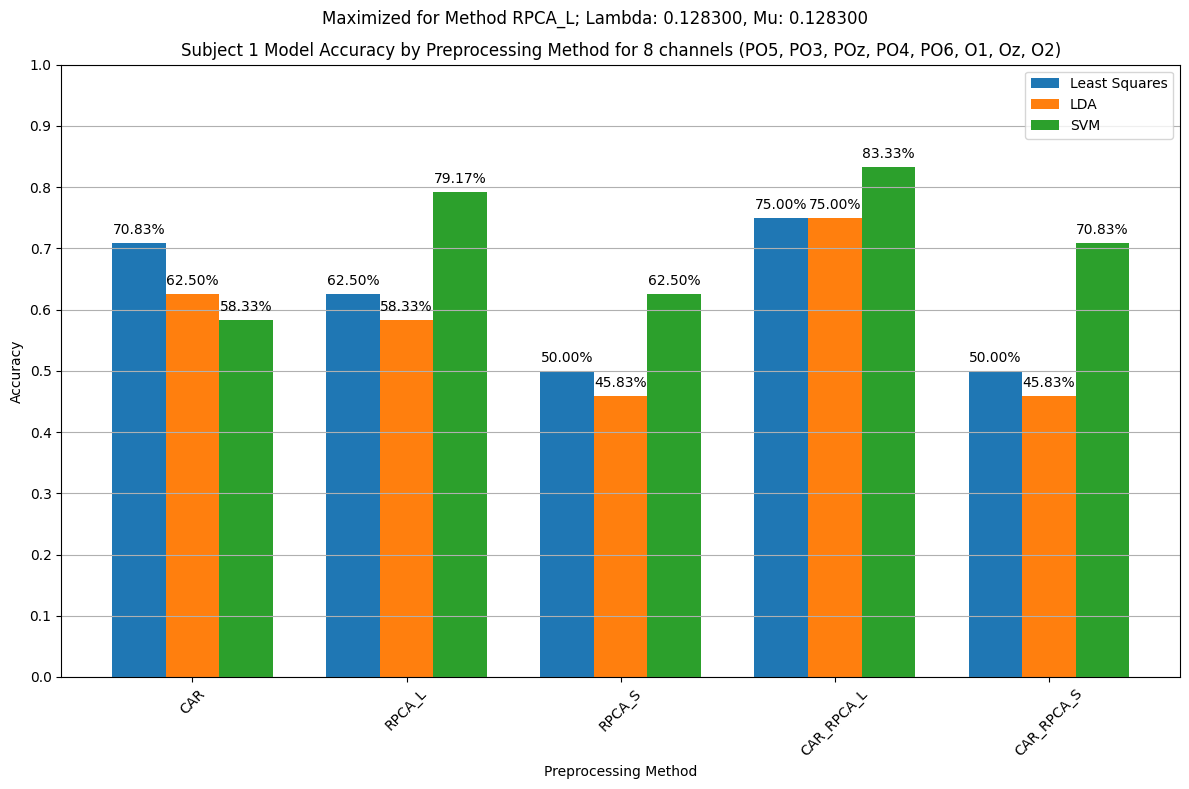


Accuracies for CAR preprocessing:
LS Accuracy: 70.83%
LDA Accuracy: 62.50%
SVM Accuracy: 58.33%

Accuracies for RPCA_L preprocessing:
LS Accuracy: 41.67%
LDA Accuracy: 45.83%
SVM Accuracy: 58.33%

Accuracies for RPCA_S preprocessing:
LS Accuracy: 62.50%
LDA Accuracy: 62.50%
SVM Accuracy: 95.83%

Accuracies for CAR_RPCA_L preprocessing:
LS Accuracy: 50.00%
LDA Accuracy: 50.00%
SVM Accuracy: 50.00%

Accuracies for CAR_RPCA_S preprocessing:
LS Accuracy: 62.50%
LDA Accuracy: 58.33%
SVM Accuracy: 58.33%
Accuracy comparison chart saved to results/accuracy_comparison_8_maximized_for_RPCA_S.png


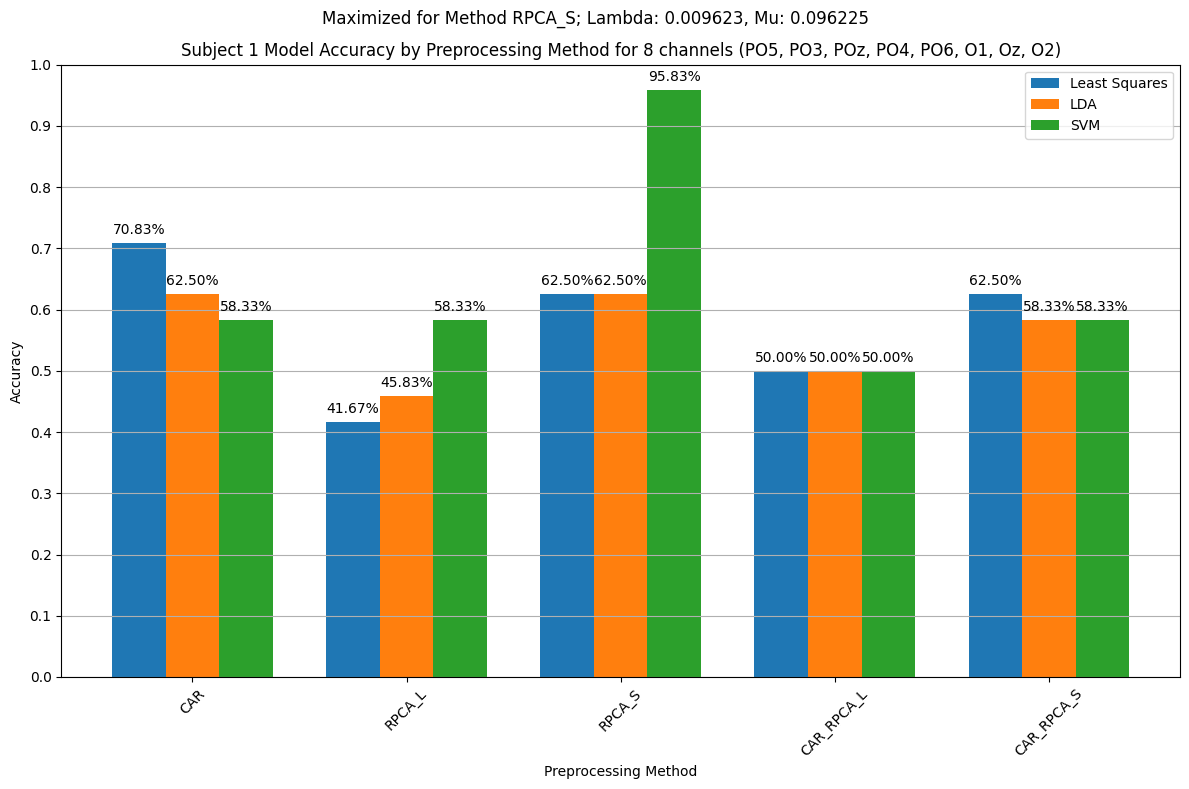


Accuracies for CAR preprocessing:
LS Accuracy: 70.83%
LDA Accuracy: 62.50%
SVM Accuracy: 58.33%

Accuracies for RPCA_L preprocessing:
LS Accuracy: 75.00%
LDA Accuracy: 66.67%
SVM Accuracy: 70.83%

Accuracies for RPCA_S preprocessing:
LS Accuracy: 70.83%
LDA Accuracy: 58.33%
SVM Accuracy: 79.17%

Accuracies for CAR_RPCA_L preprocessing:
LS Accuracy: 75.00%
LDA Accuracy: 83.33%
SVM Accuracy: 87.50%

Accuracies for CAR_RPCA_S preprocessing:
LS Accuracy: 66.67%
LDA Accuracy: 66.67%
SVM Accuracy: 83.33%
Accuracy comparison chart saved to results/accuracy_comparison_8_maximized_for_CAR_RPCA_L.png


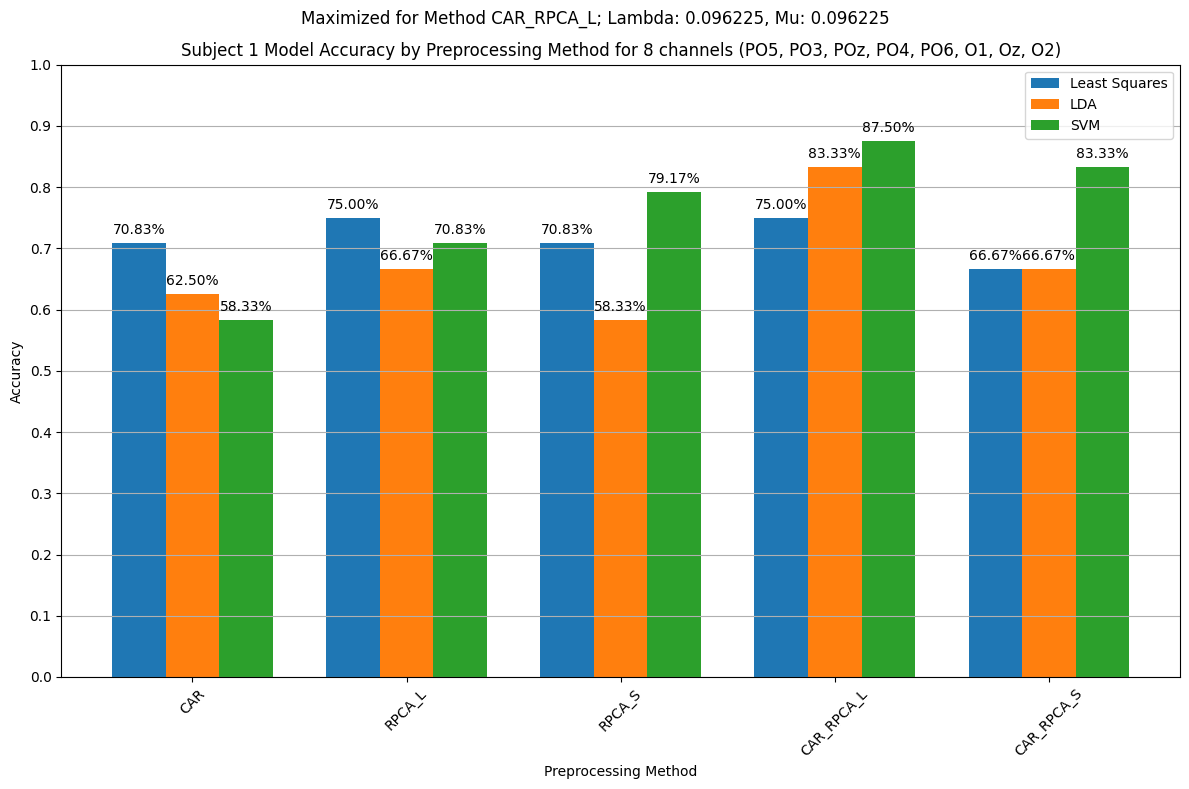


Accuracies for CAR preprocessing:
LS Accuracy: 70.83%
LDA Accuracy: 62.50%
SVM Accuracy: 58.33%

Accuracies for RPCA_L preprocessing:
LS Accuracy: 45.83%
LDA Accuracy: 54.17%
SVM Accuracy: 66.67%

Accuracies for RPCA_S preprocessing:
LS Accuracy: 58.33%
LDA Accuracy: 54.17%
SVM Accuracy: 70.83%

Accuracies for CAR_RPCA_L preprocessing:
LS Accuracy: 33.33%
LDA Accuracy: 33.33%
SVM Accuracy: 70.83%

Accuracies for CAR_RPCA_S preprocessing:
LS Accuracy: 70.83%
LDA Accuracy: 70.83%
SVM Accuracy: 87.50%
Accuracy comparison chart saved to results/accuracy_comparison_8_maximized_for_CAR_RPCA_S.png


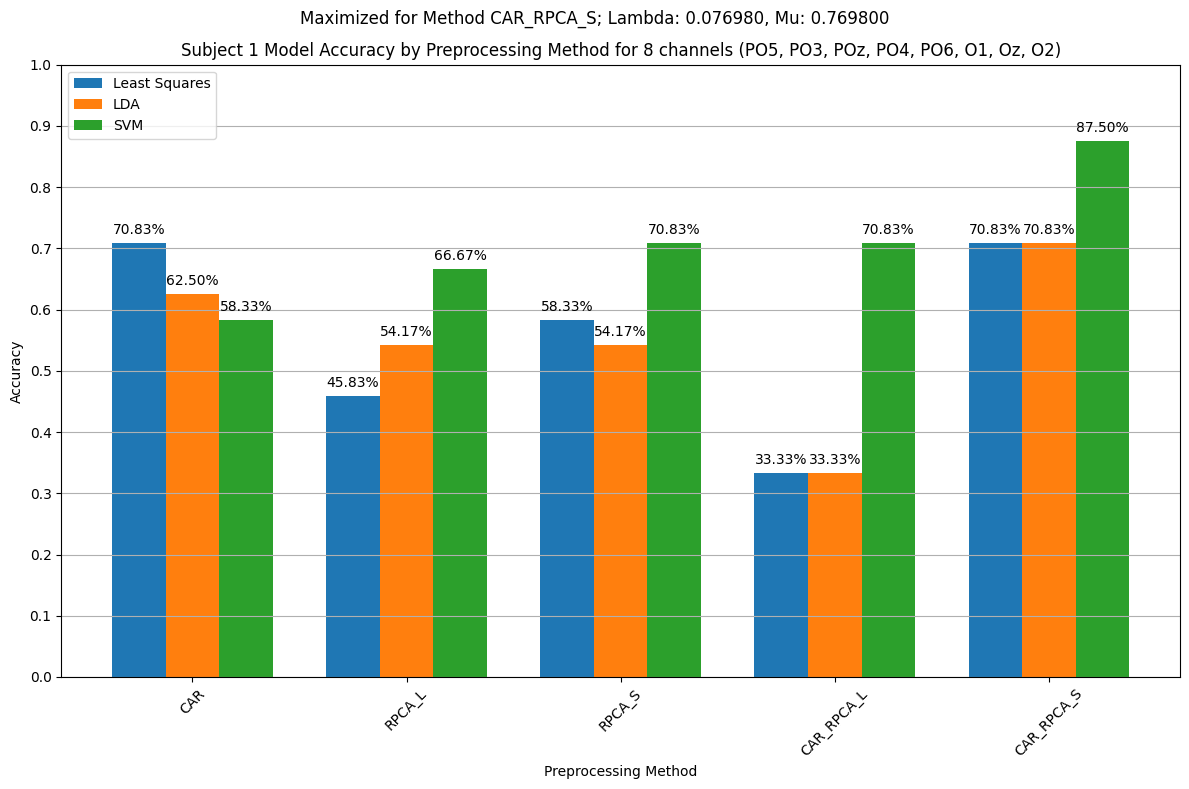


Results saved to results/model_accuracies_maximized.csv


: 

In [ ]:
# Calculate and display accuracies for each preprocessing method
import os
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np

# Create results directory if it doesn't exist
os.makedirs('code/results', exist_ok=True)

# Initialize a pandas Series to hold accuracy DataFrames for each method, similar to a dict
accuracies_by_preprocessing_method = pd.Series(
    [None]*5,
    index=["CAR", "RPCA_L", "RPCA_S", "CAR_RPCA_L", "CAR_RPCA_S"],
    dtype=object
)

for i, preprocessing_method in enumerate(X_LIST_BY_PREPROCESSING_METHOD.keys()):
    if preprocessing_method == 'CAR':
        continue

    # Initialize lists to store accuracies
    ls_accuracies = []
    lda_accuracies = []
    svm_accuracies = []

    Y_vector_validation = Y_vector_validation_by_preprocessing_method[preprocessing_method][0]
    Y_matrix_validation = Y_matrix_validation_by_preprocessing_method[preprocessing_method][0]
    Y_least_squares_pred_list = Y_least_squares_pred_list_by_preprocessing_method[preprocessing_method]
    Y_lda_pred_list = Y_lda_pred_list_by_preprocessing_method[preprocessing_method]
    Y_svm_pred_list = Y_svm_pred_list_by_preprocessing_method[preprocessing_method]

    # Calculate accuracies for each preprocessing method
    for j, method in enumerate(preprocessing_methods):
        ls_acc = accuracy_score(Y_vector_validation, Y_least_squares_pred_list[j])
        lda_acc = accuracy_score(Y_vector_validation, Y_lda_pred_list[j])
        svm_acc = accuracy_score(Y_vector_validation, Y_svm_pred_list[j])

        ls_accuracies.append(ls_acc)
        lda_accuracies.append(lda_acc)
        svm_accuracies.append(svm_acc)

        print(f"\nAccuracies for {method} preprocessing:")
        print(f"LS Accuracy: {ls_acc * 100:.2f}%")
        print(f"LDA Accuracy: {lda_acc * 100:.2f}%")
        print(f"SVM Accuracy: {svm_acc * 100:.2f}%")

    # Create a DataFrame to store the results
    results_df = pd.DataFrame({
        'Maximized for Method': preprocessing_method,
        'Preprocessing Method': preprocessing_methods,
        'Least Squares Accuracy': [acc * 100 for acc in ls_accuracies],
        'LDA Accuracy': [acc * 100 for acc in lda_accuracies],
        'SVM Accuracy': [acc * 100 for acc in svm_accuracies]
    })

    accuracies_by_preprocessing_method[preprocessing_method] = results_df

    # Create bar chart
    plt.figure(figsize=(12, 8))
    x = np.arange(len(preprocessing_methods))
    width = 0.25

    bars_ls = plt.bar(x - width, ls_accuracies, width, label='Least Squares')
    bars_lda = plt.bar(x, lda_accuracies, width, label='LDA')
    bars_svm = plt.bar(x + width, svm_accuracies, width, label='SVM')

    # Add numbers above each bar
    for idx, bar in enumerate(bars_ls):
        height = bar.get_height()
        plt.text(bar.get_x() + bar.get_width()/2, height + 0.01, f"{ls_accuracies[idx]*100:.2f}%", ha='center', va='bottom', fontsize=10)
    for idx, bar in enumerate(bars_lda):
        height = bar.get_height()
        plt.text(bar.get_x() + bar.get_width()/2, height + 0.01, f"{lda_accuracies[idx]*100:.2f}%", ha='center', va='bottom', fontsize=10)
    for idx, bar in enumerate(bars_svm):
        height = bar.get_height()
        plt.text(bar.get_x() + bar.get_width()/2, height + 0.01, f"{svm_accuracies[idx]*100:.2f}%", ha='center', va='bottom', fontsize=10)

    plt.xlabel('Preprocessing Method')
    plt.ylabel('Accuracy')
    plt.title(f'Subject {subject} Model Accuracy by Preprocessing Method for {len(selected_channels)} channels ({", ".join(selected_channels.keys())})')
    plt.suptitle(f'Maximized for Method {preprocessing_method}; Lambda: {best_lamb_spectogram_list[i]:.6f}, Mu: {best_mu_spectogram_list[i]:.6f}')
    plt.xticks(x, preprocessing_methods, rotation=45)
    plt.ylim(0, 1.0)
    plt.yticks(np.arange(0, 1.1, 0.1))  # Set y-ticks with 0.1 step
    plt.grid(axis='y')  # Add horizontal grid lines
    plt.legend()
    plt.tight_layout()

    # Save the figure
    plt.savefig(f'results/accuracy_comparison_{len(selected_channels)}_maximized_for_{preprocessing_method}.png')
    print(f"Accuracy comparison chart saved to results/accuracy_comparison_{len(selected_channels)}_maximized_for_{preprocessing_method}.png")

    # Display the plot
    plt.show()

# Save results to CSV
accuracies_by_preprocessing_method.to_csv(f'results/model_accuracies_maximized.csv', index=False)
print(f"\nResults saved to results/model_accuracies_maximized.csv")
